In [60]:
import datajoint as dj
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import datetime

import behav_viz.utils.plot_utils as pu

dj.blob.use_32bit_dims = True  # not using blob columns
sns.set_context("talk")

## 1. Load Data

Loading any animal that was trained on PWM since I joined the lab (can either be rat or mouse)

In [2]:
bdata = dj.create_virtual_module("bdata", "bdata")
ratinfo = dj.create_virtual_module("intfo", "ratinfo")

In [3]:
print(bdata.Sessions.describe())

# data from all rat sessions
sessid               : int                          
---
ratname=""           : varchar(30)                  
hostname=""          : varchar(30)                  
experimenter=""      : varchar(30)                  
starttime="00:00:00" : time                         
endtime="00:00:00"   : time                         
sessiondate="0000-00-00" : date                         
n_done_trials=0      : int                          
comments=null        : varchar(1000)                
settings_file=""     : varchar(200)                 
settings_path=""     : varchar(200)                 
data_file=""         : varchar(200)                 
data_path=""         : varchar(200)                 
video_file=""        : varchar(200)                 
video_path=""        : varchar(200)                 
protocol=""          : varchar(30)                  
total_correct=null   : float(2,2)                   
right_correct=null   : float(2,2)                   
left_corr

In [466]:
key = {"protocol": "PWM"}
pwm_df = pd.DataFrame(
    (bdata.Sessions & key & 'sessiondate > "2020-05-01"').fetch(as_dict=True)
)

## 1.2 Clean Data

In [467]:
experimenters = pwm_df.experimenter.unique()
animals = pwm_df.ratname.unique()
print(f"Experimenters: {experimenters}")
print(f"Animals: {animals}")

Experimenters: ['Emily' 'Chuck' 'Thomas' 'Jess' 'Josh' 'Jorge']
Animals: ['E145' 'E120' 'E139' 'K352' 'T287' 'K331' 'E135' 'E134' 'E114' 'E116'
 'E117' 'E121' 'E131' 'E125' 'E119' 'E159' 'E138' 'E160' 'E161' 'D084'
 'D083' 'D086' 'D087' 'D088' 'D085' 'R002' 'R001' 'R004' 'R003' 'D094'
 'D093' 'D100' 'D099' 'E164' 'E166' 'E167' 'E169' 'E168' 'E171' 'E170'
 'D104' 'D103' 'D102' 'D101' 'E165' 'I002' 'E173' 'E174' 'E175' 'E172'
 'I003' 'Y003' 'Y004' 'Y001' 'Y002' 'Y005' 'Y006' 'Y008' 'Y007']


In [468]:
# Remove Josh since these are bpod testing animals
pwm_df = pwm_df.query("experimenter != 'Josh'").copy()

y_animals_pwm2 = ["Y005", "Y006", "Y007", "Y008"]  # PWM2 animals
pwm_df = pwm_df.query("ratname not in @y_animals_pwm2").copy()

# Mark species
pwm_df["species"] = "rat"
pwm_df.loc[pwm_df.ratname.str.contains("D"), "species"] = "mouse"

# drop animals with < 50 sessions
n_sessions_df = pwm_df.groupby("ratname").sessiondate.count().reset_index()
n_sessions_df.rename(columns={"sessiondate": "n_sessions"}, inplace=True)
valid_animals = n_sessions_df.query("n_sessions > 50").ratname.values
pwm_df = pwm_df.query("ratname in @valid_animals").copy()
pwm_df = pwm_df.query("n_done_trials > 1").copy()

[Text(0.5, 1.0, 'Number of sessions per animal'),
 Text(0.5, 0, 'Animal'),
 Text(0, 0.5, 'Number of sessions')]

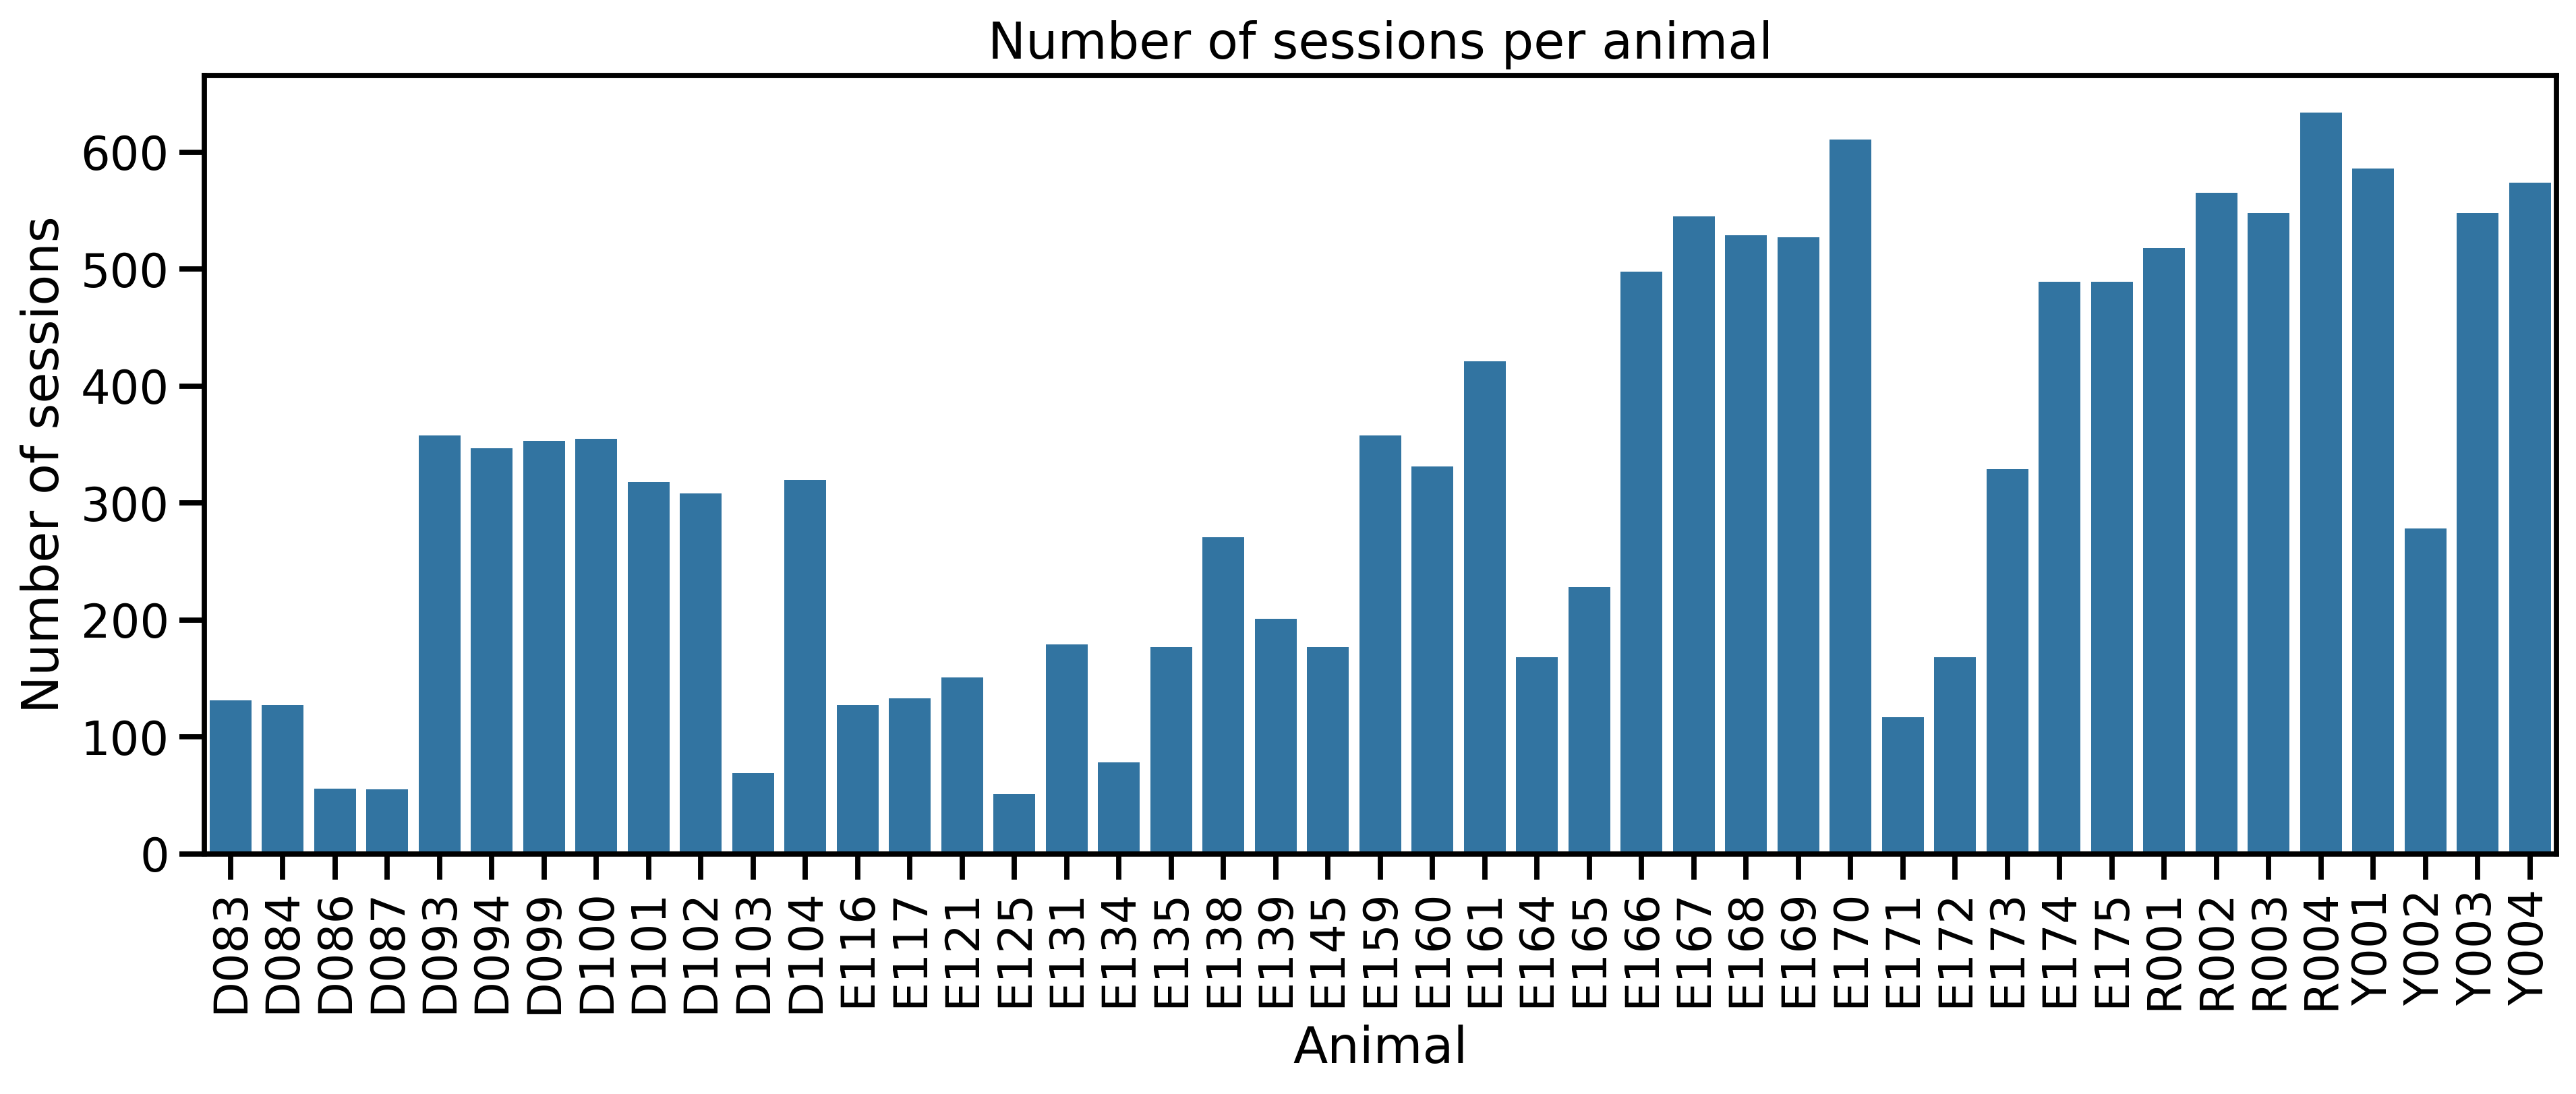

In [469]:
fig, ax = pu.make_fig((15, 5))
sns.barplot(
    n_sessions_df.query("ratname in @valid_animals"),
    x="ratname",
    y="n_sessions",
)

ax.tick_params(axis="x", rotation=90)
ax.set(
    title="Number of sessions per animal",
    xlabel="Animal",
    ylabel="Number of sessions",
)

## 1.3 Label Stages

In [470]:
pwm_df.comments

0        always, t= 16, v= 1.00, h= NaN\ndelta=6.9\n lo...
2        delayed, t= 236, v= 0.99, h= 0.50\ndelta=6.9\n...
4        always, t= 3, v= 1.00, h= NaN\ndelta=6.9\n lou...
5        delayed, t= 161, v= 0.99, h= 1.00\ndelta=6.9\n...
7        always, t= 5, v= 1.00, h= NaN\ndelta=4.9\n lou...
                               ...                        
14908    11 never, t= 157, v= 0.18, h= 0.66\ndelta=5.0\...
14909    11 never, t= 185, v= 0.11, h= 0.68\ndelta=5.0\...
14910    11 never, t= 124, v= 0.13, h= 0.65\ndelta=5.0\...
14911    11 never, t= 282, v= 0.20, h= 0.67\ndelta=5.0\...
14912    11 never, t= 172, v= 0.17, h= 0.78\ndelta=5.0\...
Name: comments, Length: 13726, dtype: object

In [473]:
def determine_stage(row):
    if "comments" not in row:
        return "unknown"

    comment = row["comments"]
    if isinstance(comment, str):
        if "grow" in comment.lower():
            return "gnp", 2
        elif "always" in comment.lower():
            return "always", 3
        elif "delayed" in comment.lower():
            return "delayed", 4
        elif "never" in comment.lower() or "psych" in comment.lower():
            return "never", 5
        elif "learning" in comment.lower():
            return "spoke", 1
        elif "error" in comment.lower() or "unable" in comment.lower():
            return "error", np.nan
    return "unknown", 0


pwm_df[["stage_name", "stage_number"]] = pwm_df.apply(
    determine_stage, axis=1, result_type="expand"
)
pwm_df.query("stage_name == 'unknown'").comments.unique()  # no unknown stages

array([], dtype=object)

In [474]:
pwm_df = pwm_df.query("n_done_trials > 1").copy()

# 2 Determining Training Success

Now lets see how many animals actually got the rule in the never stage.

Determining training:
- rolling window of hit rate ~ 2 weeks, cross 70% threshold- see raw data & assess

Final plots
- violation rate histogram for animals that made it to the stage and do/don't train
- bar plot with number of animals trained + yeild in stages to drive home differences

In [476]:
def compute_rolling_mean(df, column, window_size):
    """
    Function to compute the rolling mean of a column for each ratname
    across sessions
    """
    grouped_over_sessions = (
        df.groupby(["ratname", "sessiondate"])[column].mean().reset_index()
    )
    rolling_mean = (
        grouped_over_sessions.groupby("ratname")
        .apply(lambda x: x[column].rolling(window=window_size, min_periods=1).mean())
        .reset_index()
    )

    rolling_mean.rename(columns={column: f"rolling_mean_{column}"}, inplace=True)
    rolling_mean["window_size"] = window_size

    return pd.merge(
        grouped_over_sessions,
        rolling_mean.drop(columns=["ratname"]),  # already in grouped df
        left_index=True,
        right_on="level_1",  # index of grouped df
        how="left",
    ).drop(columns=["level_1"])

/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_55805/1142083431.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x[column].rolling(window=window_size, min_periods=1).mean())


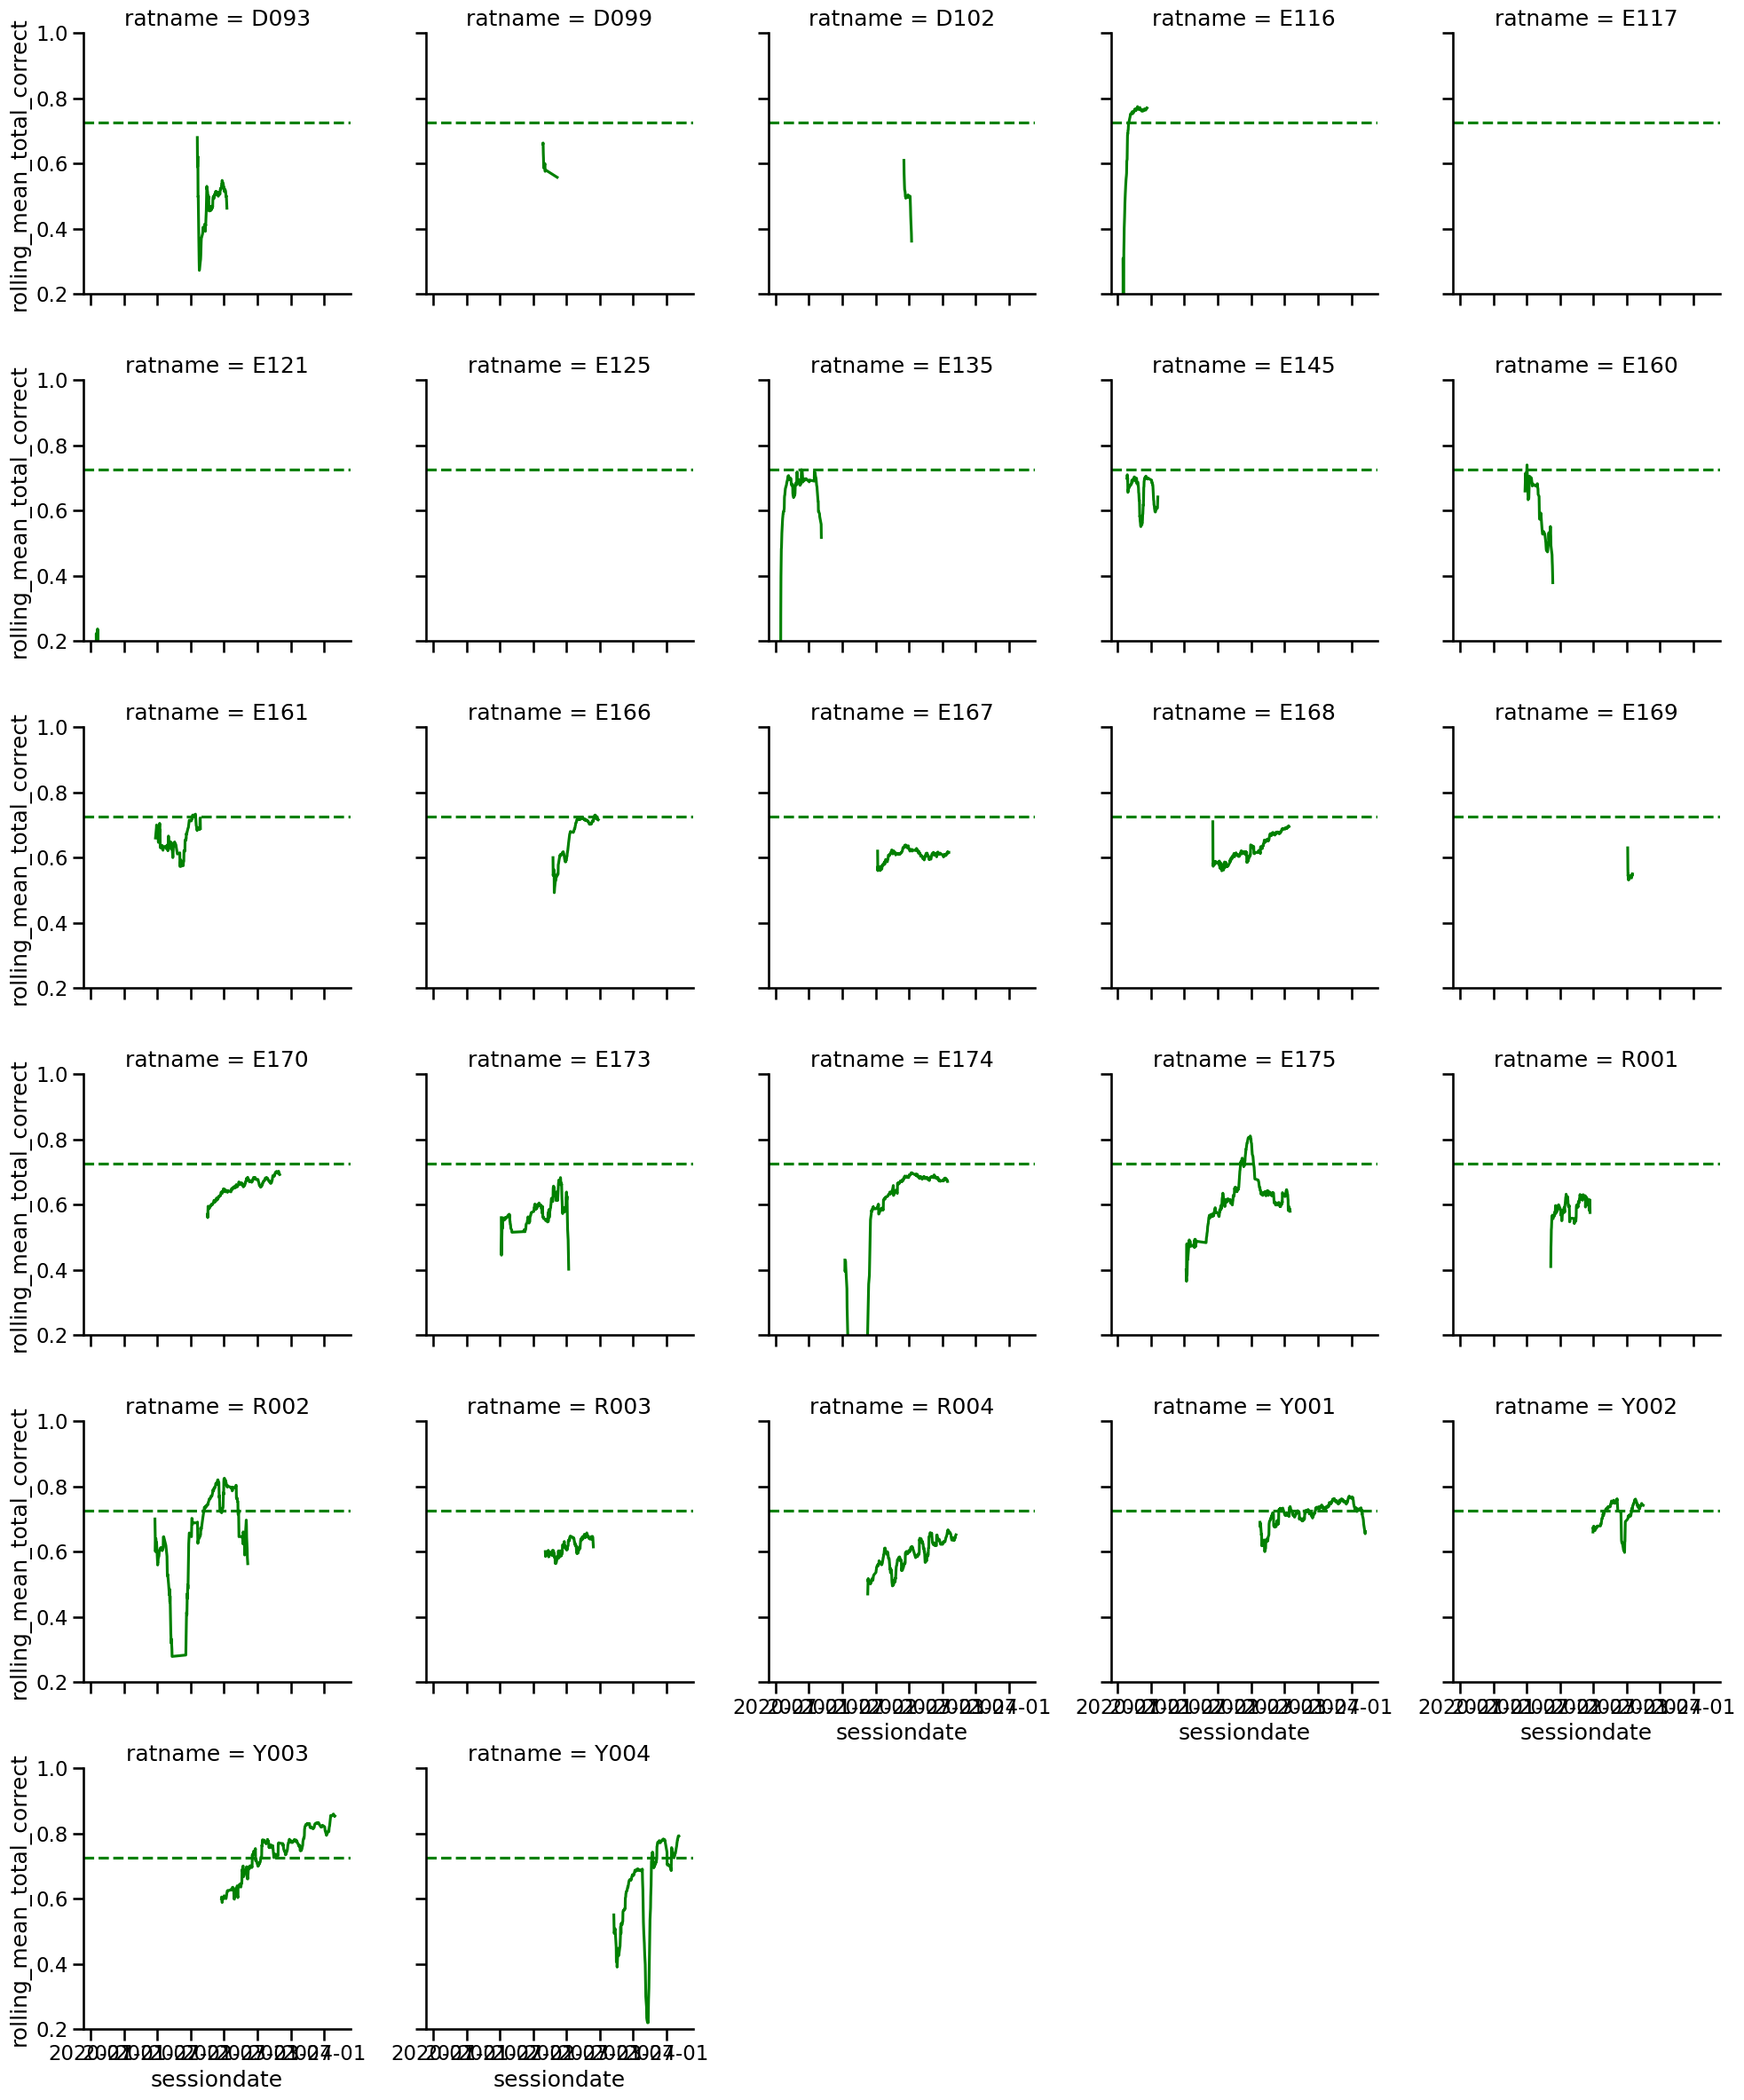

In [477]:
hit_rolling_mean = compute_rolling_mean(
    pwm_df.query("stage_name == 'never'"), "total_correct", window_size=21
)

g = sns.FacetGrid(
    data=hit_rolling_mean, col="ratname", col_wrap=5, height=4, ylim=(0.2, None)
)
g.map(sns.lineplot, "sessiondate", "rolling_mean_total_correct", color="green")
g.map(plt.axhline, y=0.725, color="green", linestyle="--")

In [546]:
trained_animals = [
    "E116",
    "R002",
    "Y001",
    "Y002",
    "Y003",
    "Y004",
]  # just doing this by eye- not going to over-complicate things


pwm_df = pwm_df.query(
    "ratname !='E117'"
).copy()  # this animal was only violating, not a fair comparison
pwm_df["trained"] = pwm_df.ratname.isin(trained_animals)

# 3. Stage properties & yeild

<Axes: xlabel='sessiondate', ylabel='stage_number'>

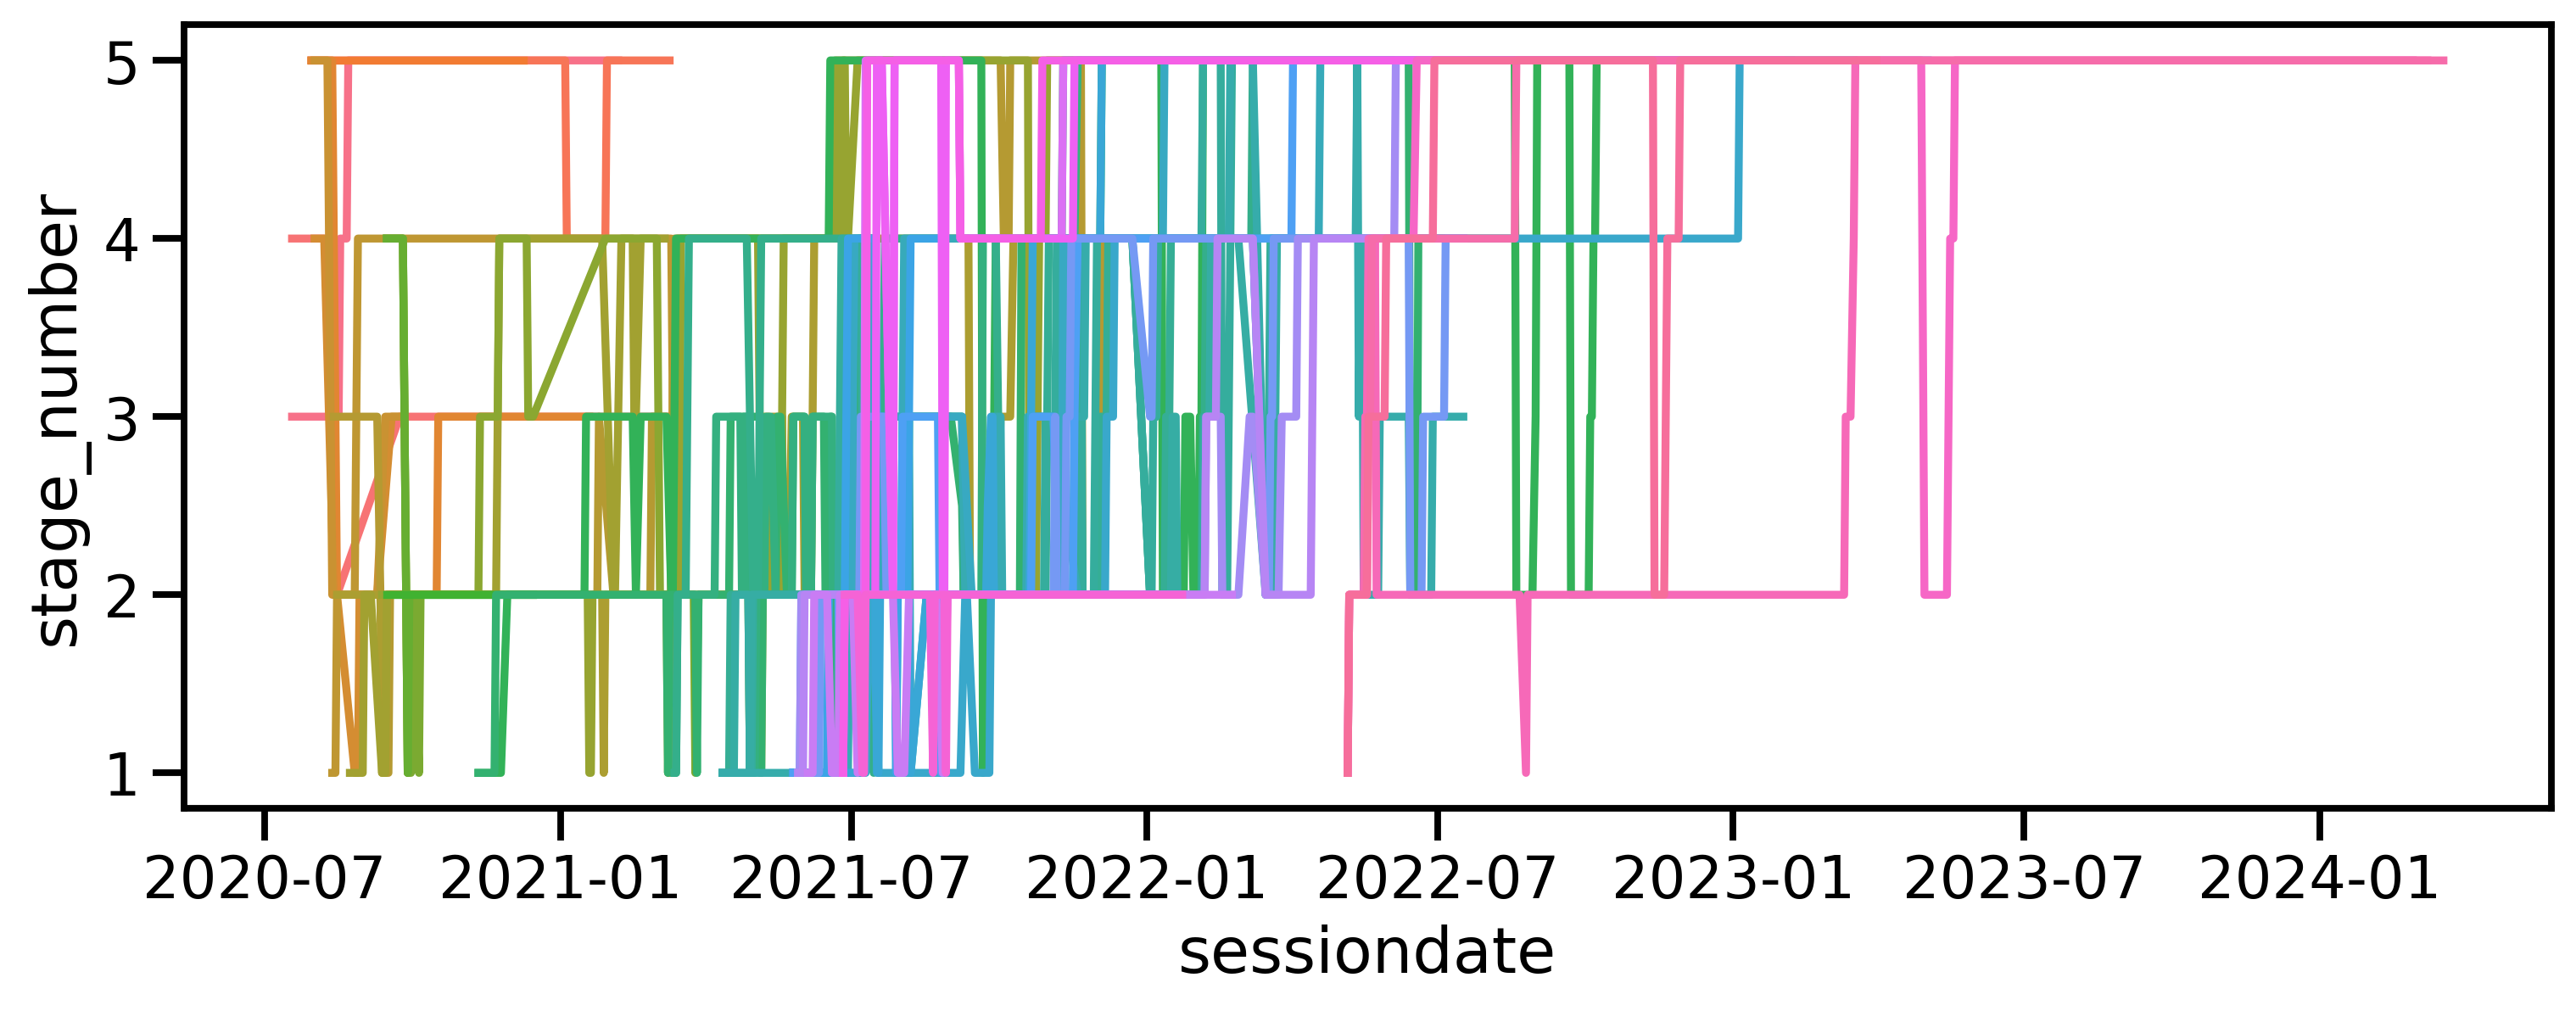

In [547]:
fig, ax = pu.make_fig()
sns.lineplot(
    data=pwm_df,
    x="sessiondate",
    y="stage_number",
    hue="ratname",
    legend=False,
)

In [548]:
# Get unique rat names for different categories
all_rats = set(pwm_df["ratname"].unique())
always_rats = set(pwm_df.query("stage_name == 'always'")["ratname"].unique())
delayed_rats = set(pwm_df.query("stage_name == 'delayed'")["ratname"].unique())
never_rats = set(pwm_df.query("stage_name == 'never'")["ratname"].unique())
gnp_rats = set(pwm_df.query("stage_name == 'gnp'")["ratname"].unique())

# Find rats not in 'never' stage but in all rats
not_never_rats = all_rats - never_rats
pwm_df["not_sound_rule"] = pwm_df.ratname.isin(not_never_rats)

in_delayed_not_always = delayed_rats - always_rats
# Find rats not in 'gnp' stage but in all rats
not_gnp_rats = all_rats - gnp_rats

## 3.1 Stage Yields 

Note this says nothing about the performance of the animal in the stage, just if they made it. Dropping always and spoke stages as they are not consistently encoded for all animals.

In [632]:
stage_counts = (
    pwm_df.groupby("stage_number")["ratname"]
    .nunique()
    .sort_index()
    .reset_index()
    .rename(columns={"ratname": "n_animals"})
)

stage_counts["stage_name"] = stage_counts["stage_number"].map(
    {
        1.0: "spoke",
        2.0: "Fixation",
        3.0: "Sound Rule 0",
        4.0: "Sound Rule Guided",
        5.0: "Sound Rule Full",
    }
)
stage_counts["completed"] = stage_counts["stage_number"].map(
    {
        1.0: "Start",
        2.0: "Spoke",
        3.0: "DROP!",  # some animals skip this stage, don't use
        4.0: "Fixation",
        5.0: "Sound Rule On",
    }
)
stage_counts.loc[len(stage_counts)] = [
    6,
    len(trained_animals),
    "Sound Rule Req",
    "Trained",
]
stage_counts["yield"] = (
    (stage_counts.n_animals / stage_counts["n_animals"].max()) * 100
).round(0)


stage_counts

stage_number  n_animals         stage_name      completed  yield
0           1.0         37              spoke          Start   90.0
1           2.0         41           Fixation          Spoke  100.0
2           3.0         33       Sound Rule 0          DROP!   80.0
3           4.0         36  Sound Rule Guided       Fixation   88.0
4           5.0         26    Sound Rule Full  Sound Rule On   63.0
5           6.0          6     Sound Rule Req        Trained   15.0

In [644]:
6 / 26

0.23076923076923078

In [634]:
pwm_df.ratname.nunique()

44

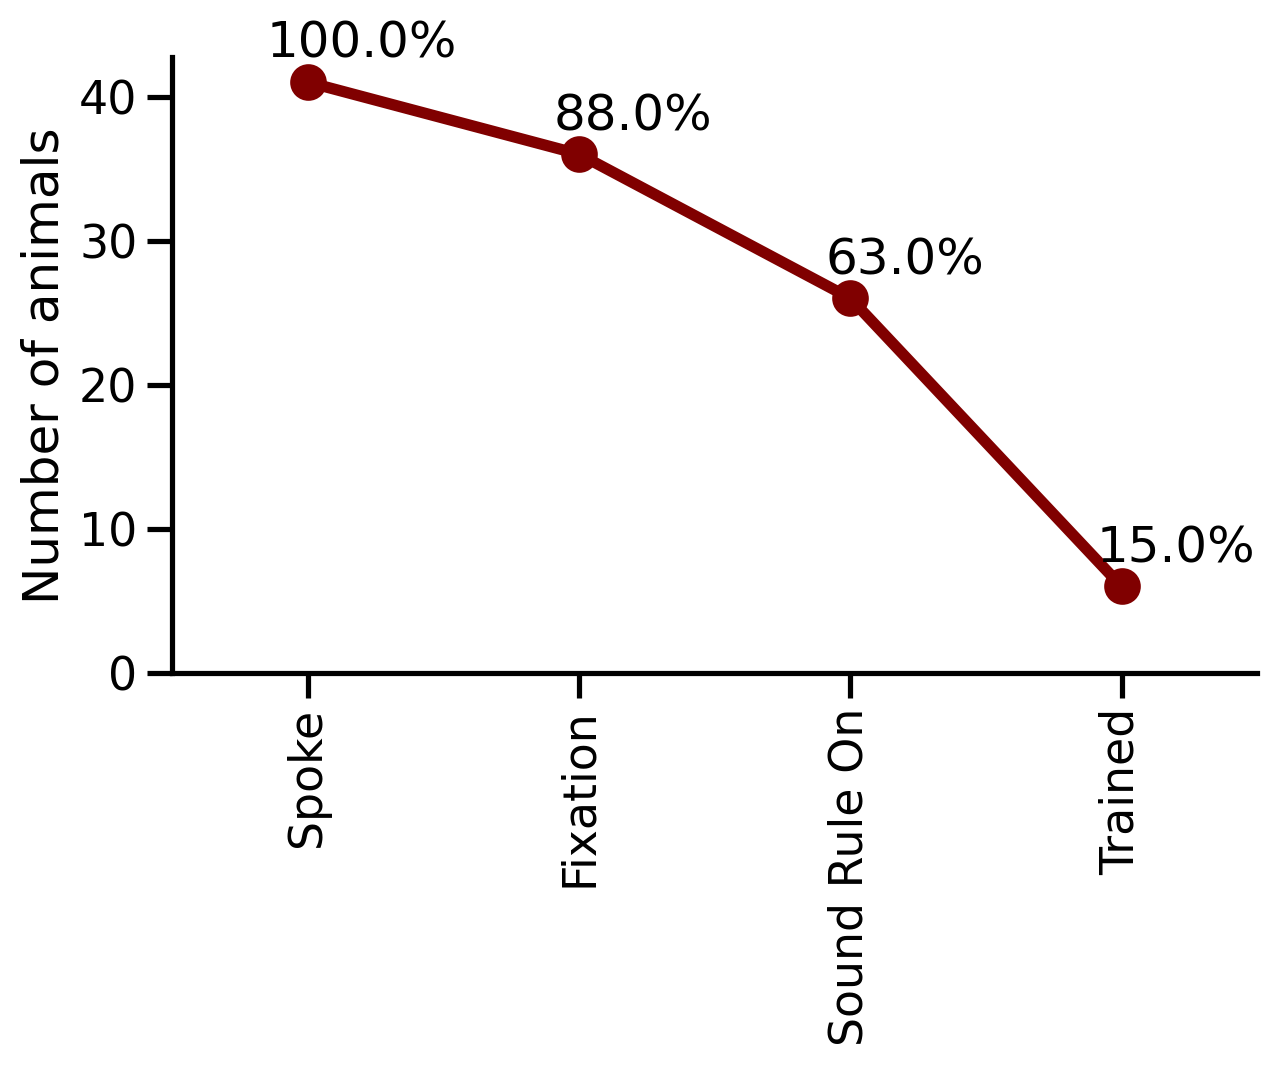

In [631]:
# looka t animals that have made it through spoke stages, don't look at "always" stage since its not consistently used
plot_df = data = stage_counts.query("stage_number > 1 and stage_number !=3")
fig, ax = plt.subplots(figsize=(7, 4), dpi=200)
# fig, ax = plt.subplots(figsize=(7, 4))

sns.pointplot(
    data=plot_df,
    x="completed",
    y="n_animals",
    ax=ax,
    color="maroon",
)

# put counts on top of bars
for i, row in (
    stage_counts.query("stage_number > 1 and stage_number !=3").reset_index().iterrows()
):
    ax.text(
        i + 0.2,
        row["n_animals"] + 1,
        str(row["yield"]) + "%",
        ha="center",
        va="bottom",
        color="black",
    )

ax.set(
    xlabel="",
    ylabel="Number of animals",
    ylim=(0, None),
)
ax.tick_params(axis="x", rotation=90)

sns.despine()

## 3.2 Finished sound rule on/soft stage Vs Failed to Reach

In [679]:
# Lets only look at center poking stages (ie drop side poke)
cpoke_df = pwm_df.query("stage_number >=2").copy()

palette = sns.color_palette("Oranges", 2)

### 3.2.1 Violation Rates of animals that completed sound rule 

With median line 

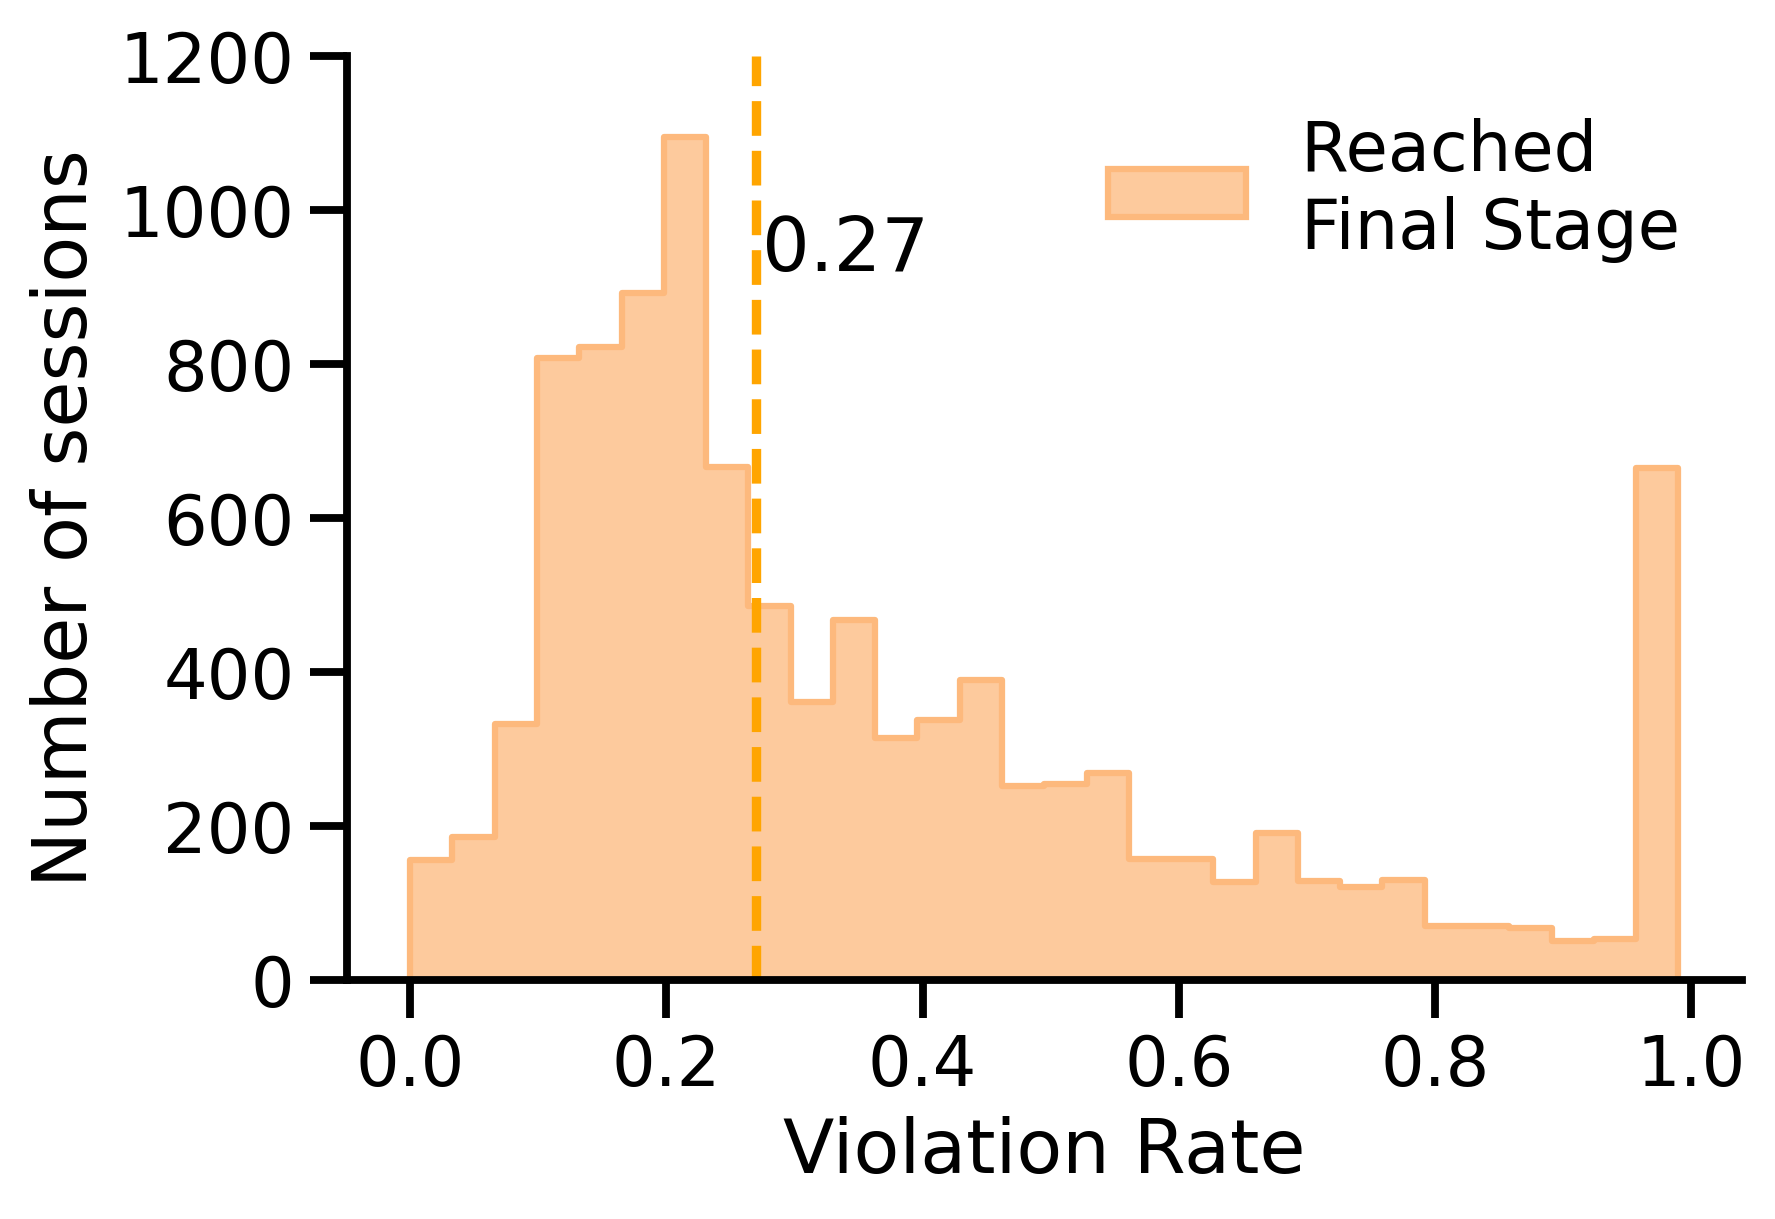

In [680]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
# animals that made it through sound rule
plot_df = cpoke_df.query("not_sound_rule == False")
sns.histplot(
    plot_df,
    x="percent_violations",
    element="step",
    color=palette[0],
    bins=30,
)

ax.legend(["Reached \nFinal Stage"], frameon=False)
ax.set(
    ylim=(0, 1200),
    ylabel="Number of sessions",
    xlabel="Violation Rate",
)

median = plot_df["percent_violations"].median()
ax.axvline(median, color="orange", linestyle="--")
ax.text(
    median + 0.07,
    900,
    f"{median:.2f}",
    ha="center",
    va="bottom",
    color="k",
)
sns.despine()

### 3.2.2 Violation Rates of animals that reached full sound rule vs animals that failed to reach

With and without median line 

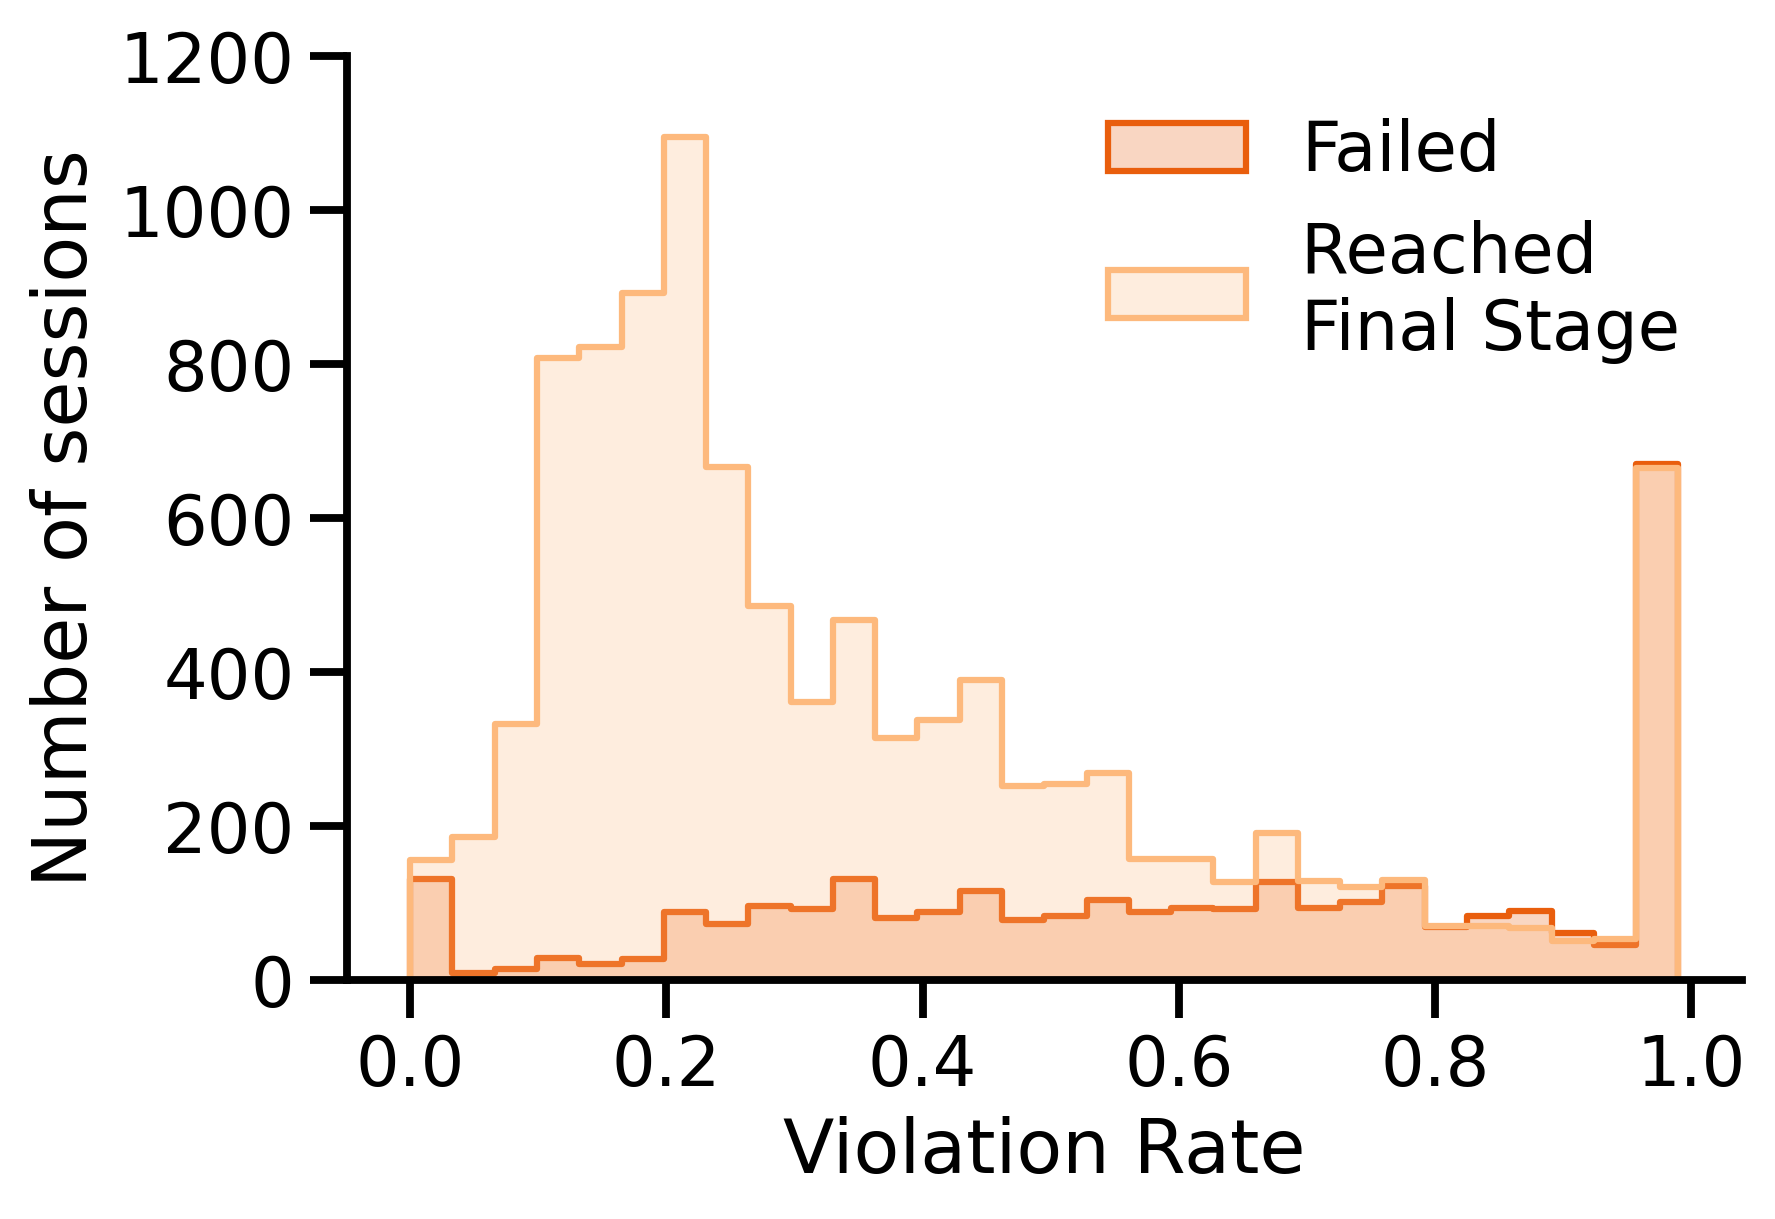

In [683]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
orange_pal = sns.color_palette("Oranges", 2)
sns.histplot(
    cpoke_df,
    x="percent_violations",
    element="step",
    hue="not_sound_rule",
    palette=palette,
    bins=30,
)
ax.legend(["Failed", "Reached \nFinal Stage"], frameon=False)
ax.set(
    ylim=(0, 1200),
    ylabel="Number of sessions",
    xlabel="Violation Rate",
)

sns.despine()

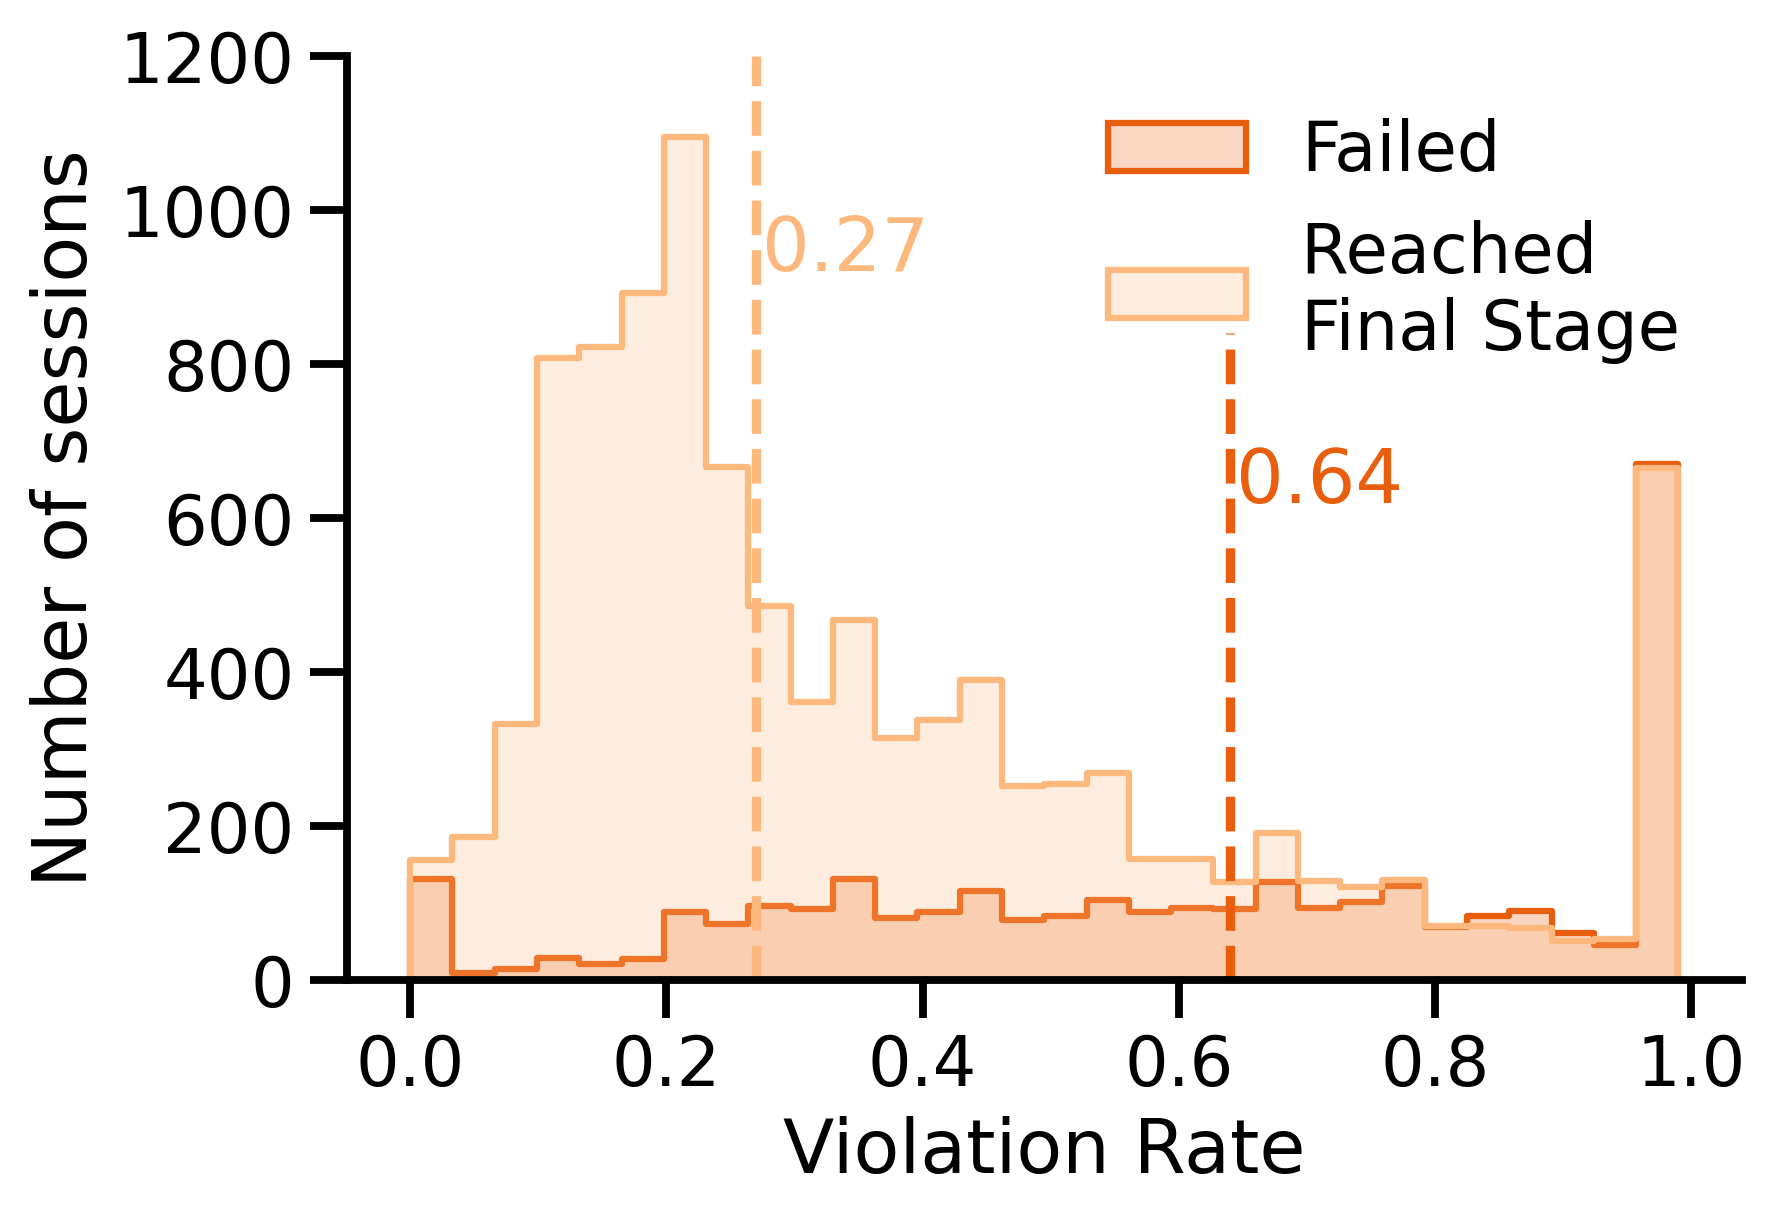

In [684]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
sns.histplot(
    cpoke_df,
    x="percent_violations",
    element="step",
    hue="not_sound_rule",
    palette=palette,
    bins=30,
)
ax.legend(["Failed", "Reached \nFinal Stage"], frameon=False)
ax.set(
    ylim=(0, 1200),
    ylabel="Number of sessions",
    xlabel="Violation Rate",
)

for condition, sub_df in cpoke_df.groupby("not_sound_rule"):
    median = sub_df["percent_violations"].median()
    if condition:
        ymax = 0.7
        ytext = 600
    else:
        ymax = 1
        ytext = 900
    ax.axvline(median, ymax=ymax, color=palette[condition], linestyle="--")
    ax.text(
        median + 0.07,
        ytext,
        f"{median:.2f}",
        ha="center",
        va="bottom",
        color=palette[condition],
    )
sns.despine()

### 3.2.3 Rat and mouse only violation rates of reached full sound rule vs failed to reach 

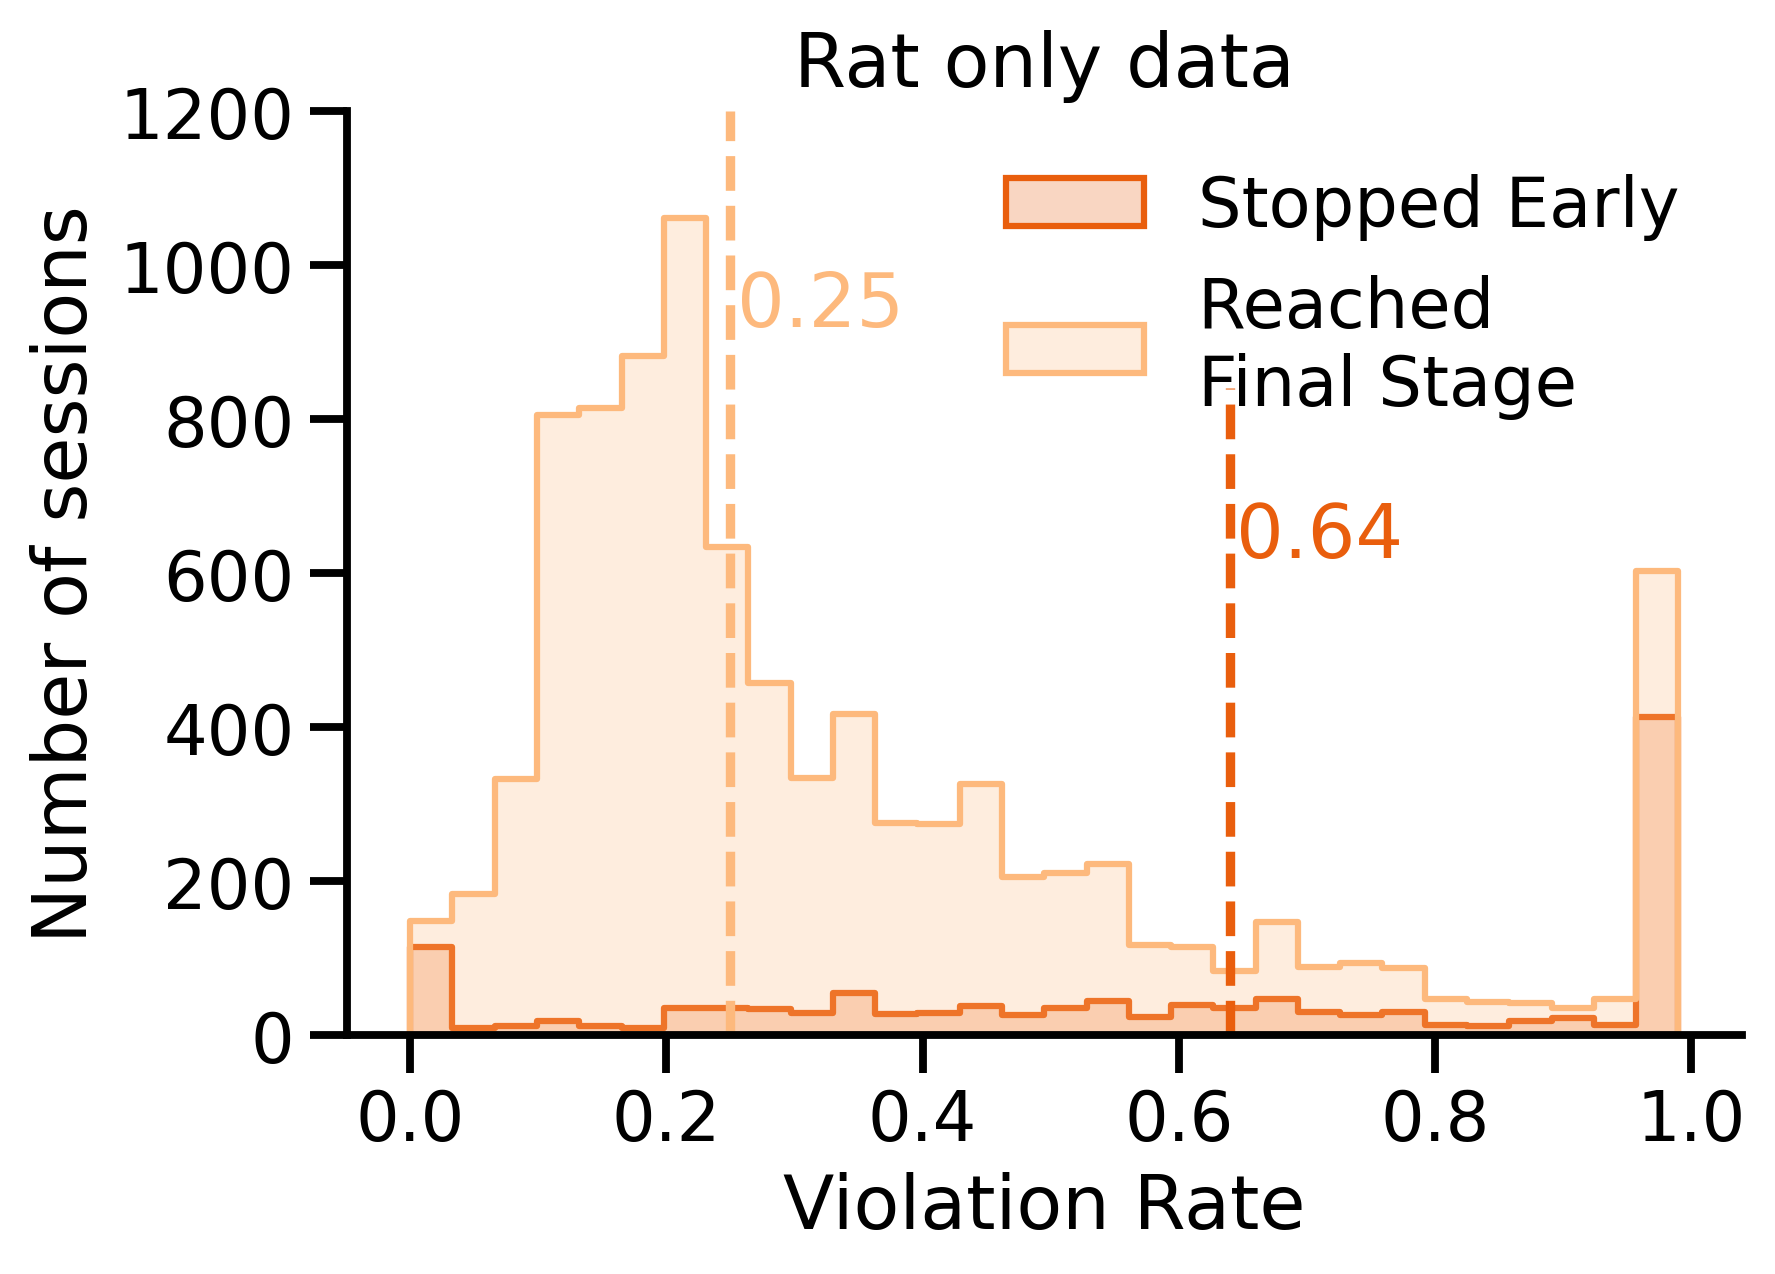

In [686]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

plot_df = cpoke_df.query("species == 'rat'")
sns.histplot(
    plot_df,
    x="percent_violations",
    element="step",
    hue="not_sound_rule",
    palette=palette,
    bins=30,
)
ax.legend(["Stopped Early", "Reached \nFinal Stage"], frameon=False)
ax.set(
    ylim=(0, 1200),
    ylabel="Number of sessions",
    xlabel="Violation Rate",
    title="Rat only data",
)

for condition, sub_df in plot_df.groupby("not_sound_rule"):
    median = sub_df["percent_violations"].median()
    if condition:
        ymax = 0.7
        ytext = 600
    else:
        ymax = 1
        ytext = 900
    ax.axvline(median, ymax=ymax, color=palette[condition], linestyle="--")
    ax.text(
        median + 0.07,
        ytext,
        f"{median:.2f}",
        ha="center",
        va="bottom",
        color=palette[condition],
    )
sns.despine()

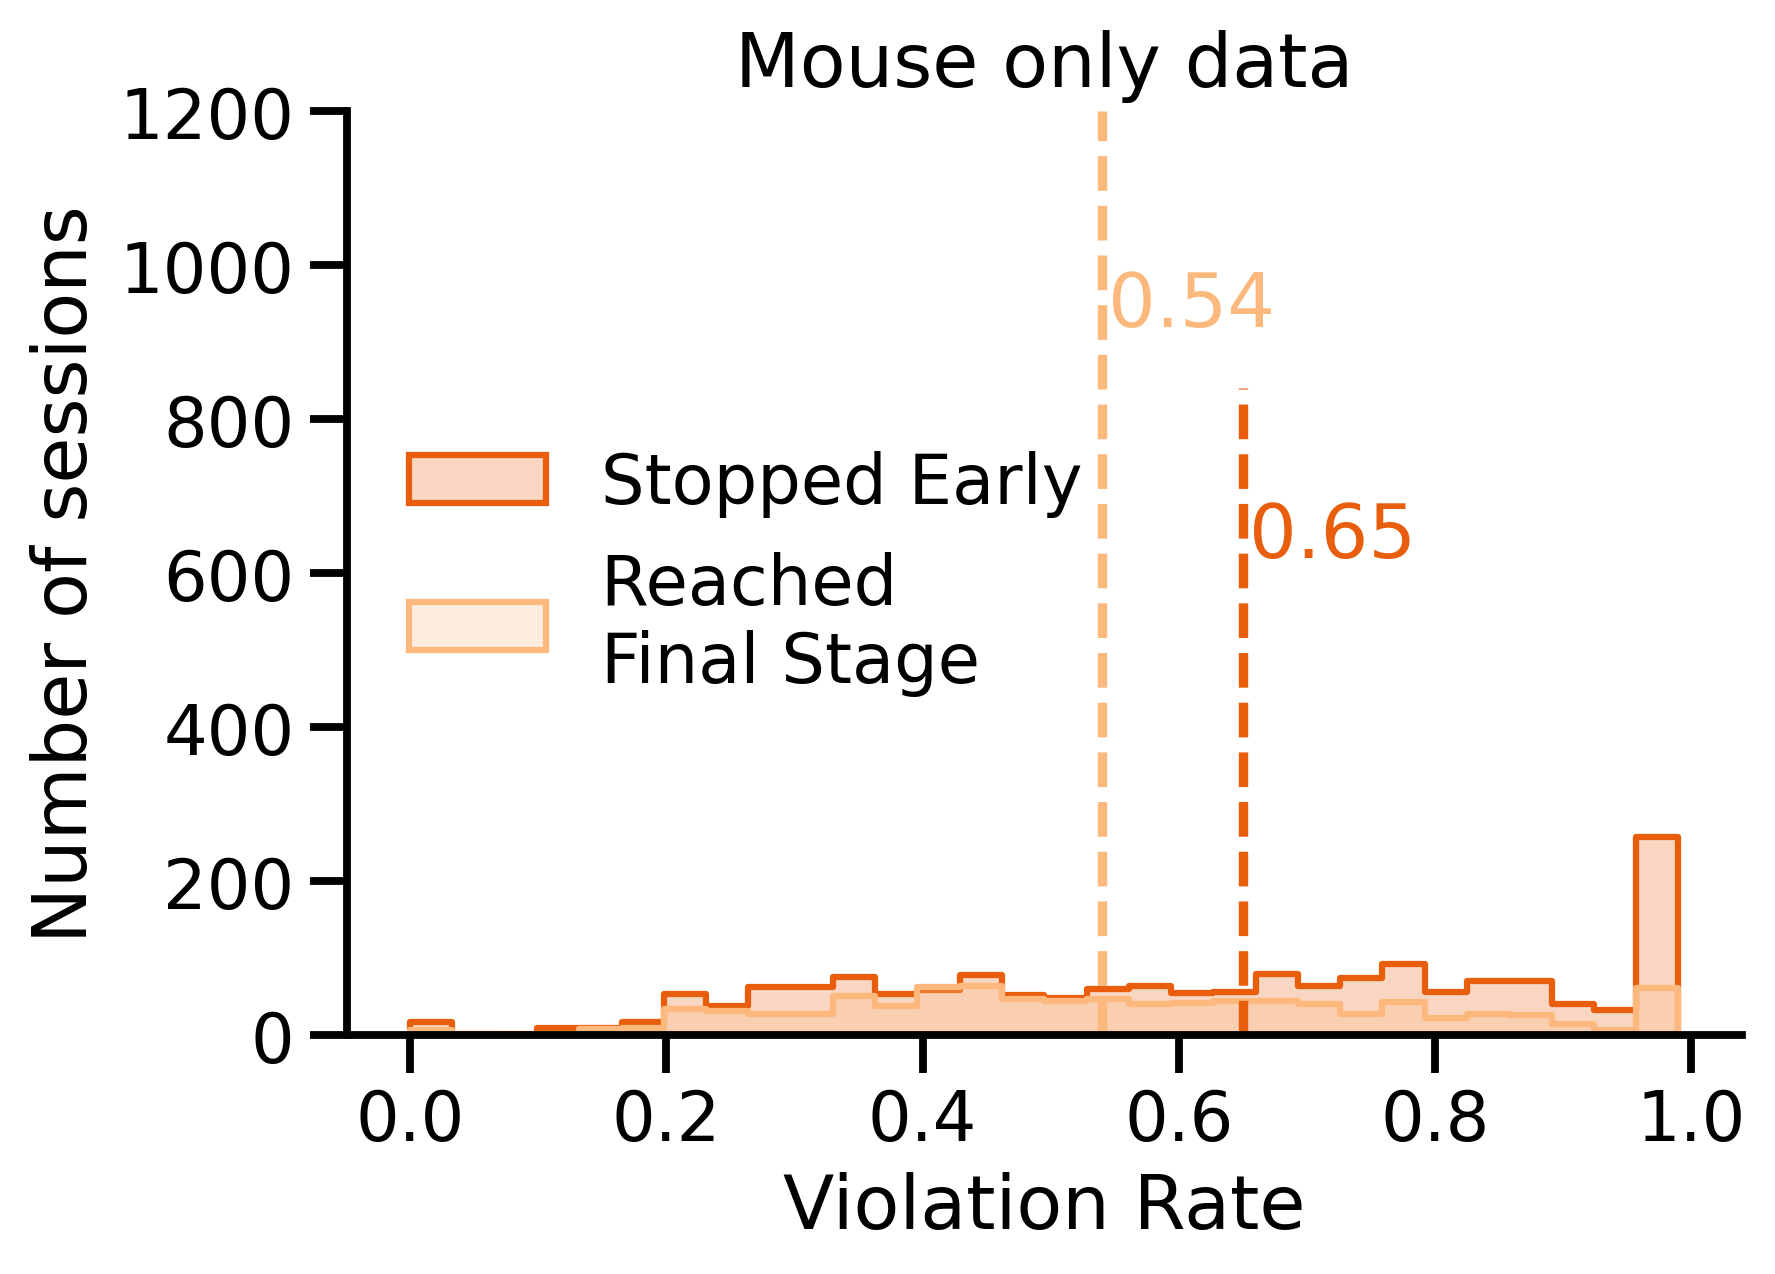

In [688]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

plot_df = cpoke_df.query("species == 'mouse'")
sns.histplot(
    plot_df,
    x="percent_violations",
    element="step",
    hue="not_sound_rule",
    palette=palette,
    bins=30,
)
ax.legend(["Stopped Early", "Reached \nFinal Stage"], frameon=False)
ax.set(
    ylim=(0, 1200),
    ylabel="Number of sessions",
    xlabel="Violation Rate",
    title="Mouse only data",
)

for condition, sub_df in plot_df.groupby("not_sound_rule"):
    median = sub_df["percent_violations"].median()
    if condition:
        ymax = 0.7
        ytext = 600
    else:
        ymax = 1
        ytext = 900
    ax.axvline(median, ymax=ymax, color=palette[condition], linestyle="--")
    ax.text(
        median + 0.07,
        ytext,
        f"{median:.2f}",
        ha="center",
        va="bottom",
        color=palette[condition],
    )
sns.despine()

### 3.3.4 Trial counts

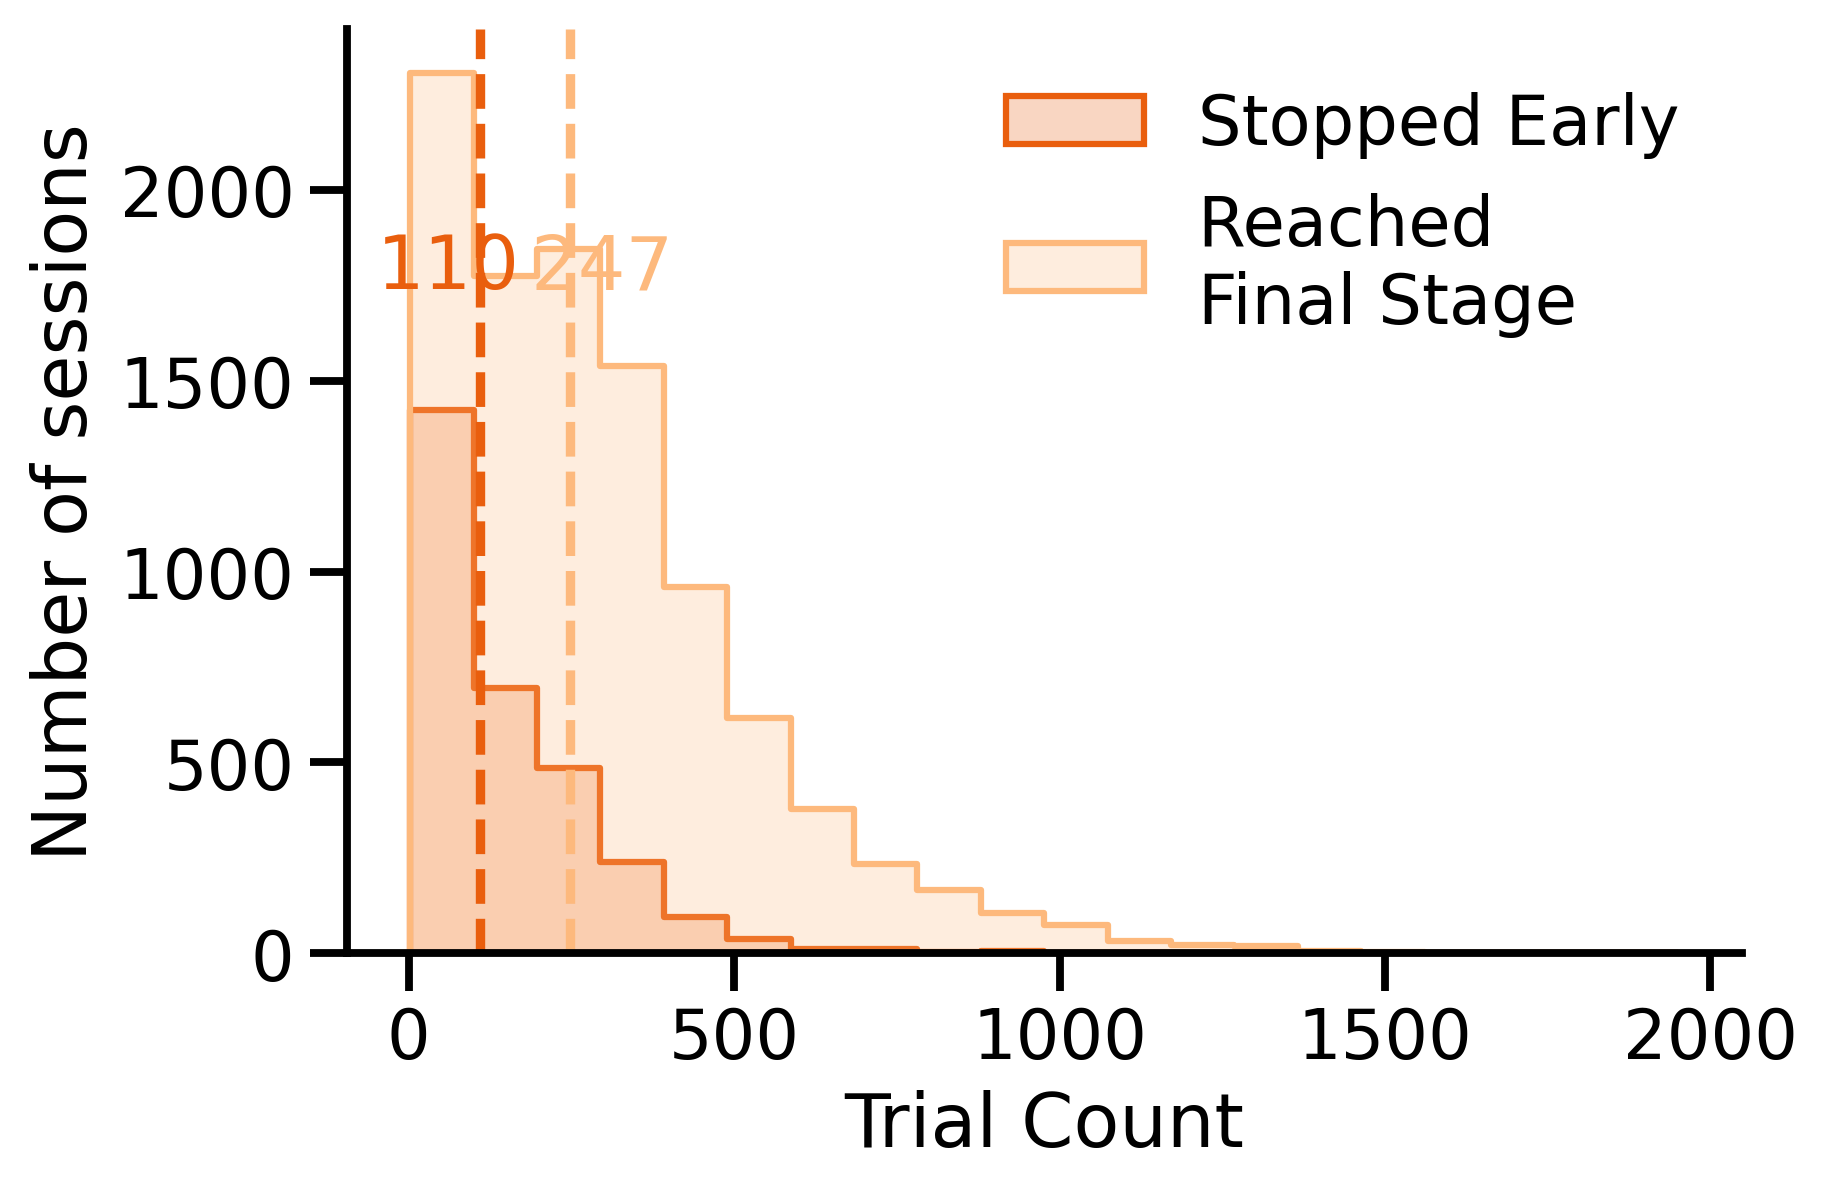

In [689]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

sns.histplot(
    cpoke_df,
    x="n_done_trials",
    element="step",
    hue="not_sound_rule",
    palette=palette,
    bins=20,
)
ax.legend(["Stopped Early", "Reached \nFinal Stage"], frameon=False)
ax.set(
    # ylim=(0, 1200),
    ylabel="Number of sessions",
    xlabel="Trial Count",
)

for condition, sub_df in cpoke_df.groupby("not_sound_rule"):
    median = sub_df["n_done_trials"].median()
    if condition:
        xloc = median - 50
    else:
        xloc = median + 50
    ax.axvline(median, color=palette[condition], linestyle="--")
    ax.text(
        xloc,
        1700,
        f"{median:.0f}",
        ha="center",
        va="bottom",
        color=palette[condition],
    )
sns.despine()

## 3.3 Trained vs Not Trained

In [721]:
palette = sns.color_palette("rocket", 2)
hue_order = [False, True]
legend_labs = ["Trained", "Not Trained"]  # weirdly backwards idk

### 3.3.1 Violation Rates for all animals, all stages trained vs not

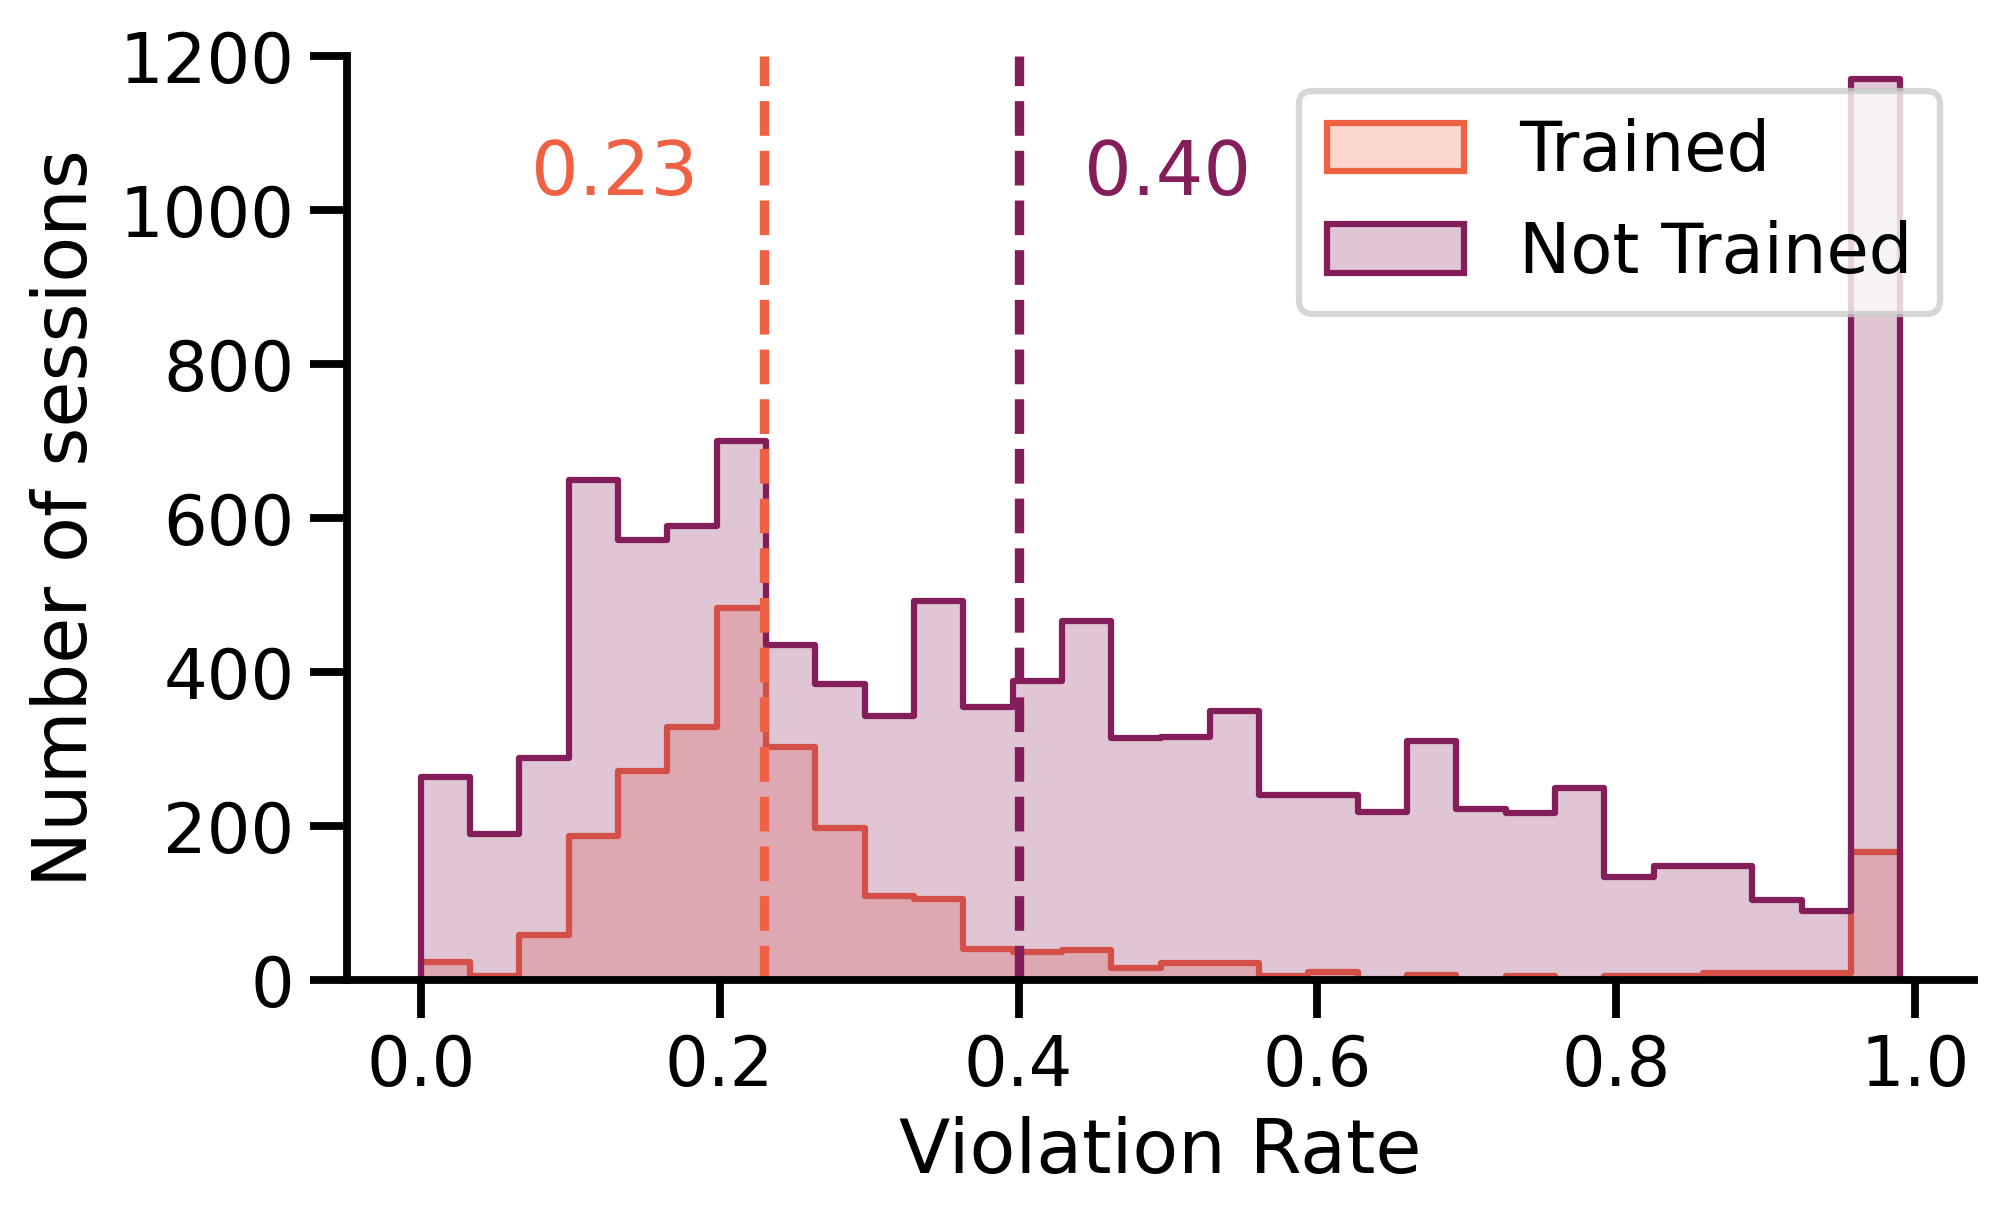

In [723]:
fig, ax = plt.subplots(figsize=(7, 4), dpi=300)

sns.histplot(
    cpoke_df,
    x="percent_violations",
    element="step",
    hue="trained",
    hue_order=hue_order,
    palette=palette,
    bins=30,
)
ax.legend(legend_labs, frameon=True, loc="upper right")
ax.set(
    ylim=(0, 1200),
    ylabel="Number of sessions",
    xlabel="Violation Rate",
)

for condition, sub_df in cpoke_df.groupby("trained"):
    median = sub_df["percent_violations"].median()

    ax.axvline(median, color=palette[condition], linestyle="--")
    if condition:
        xloc = median - 0.1
    else:
        xloc = median + 0.1
    ax.text(
        xloc,
        1000,
        f"{median:.2f}",
        ha="center",
        va="bottom",
        color=palette[condition],
    )
sns.despine()

### 3.3.2 Violation Rates for Animals that Reached the Final Stage, All Stages

In [724]:
cpoke_final_stage_animals_df = cpoke_df.query("not_sound_rule == False").copy()

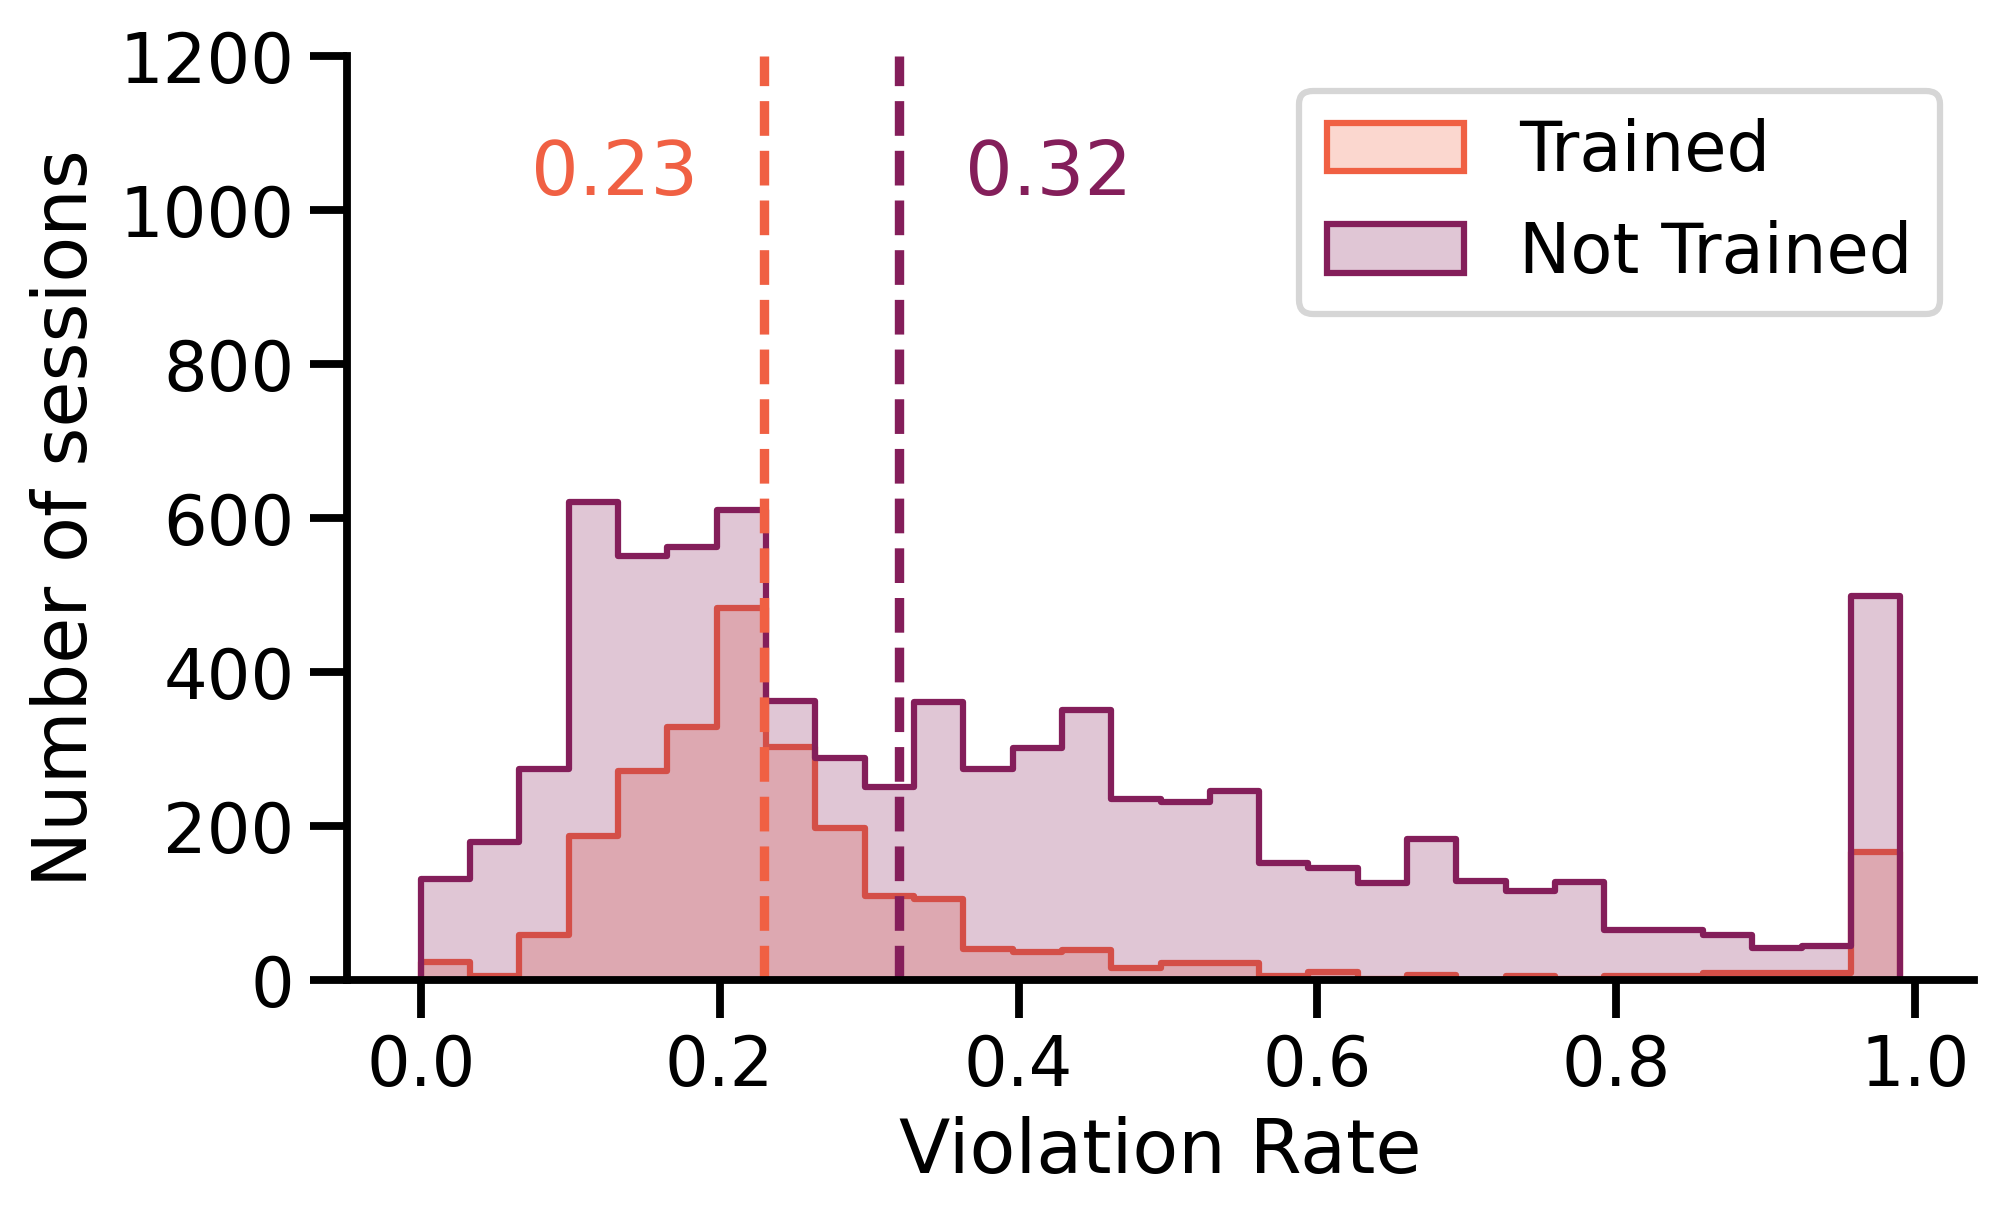

In [725]:
fig, ax = plt.subplots(figsize=(7, 4), dpi=300)

sns.histplot(
    cpoke_final_stage_animals_df,
    x="percent_violations",
    element="step",
    hue="trained",
    hue_order=hue_order,
    palette=palette,
    bins=30,
)
ax.legend(legend_labs, frameon=True, loc="upper right")
ax.set(
    ylim=(0, 1200),
    ylabel="Number of sessions",
    xlabel="Violation Rate",
)

for condition, sub_df in cpoke_final_stage_animals_df.groupby("trained"):
    median = sub_df["percent_violations"].median()

    ax.axvline(median, color=palette[condition], linestyle="--")
    if condition:
        xloc = median - 0.1
    else:
        xloc = median + 0.1
    ax.text(
        xloc,
        1000,
        f"{median:.2f}",
        ha="center",
        va="bottom",
        color=palette[condition],
    )
sns.despine()

### 3.3.3 Violation Rates for Animals that Reached the Final Stage, GNP

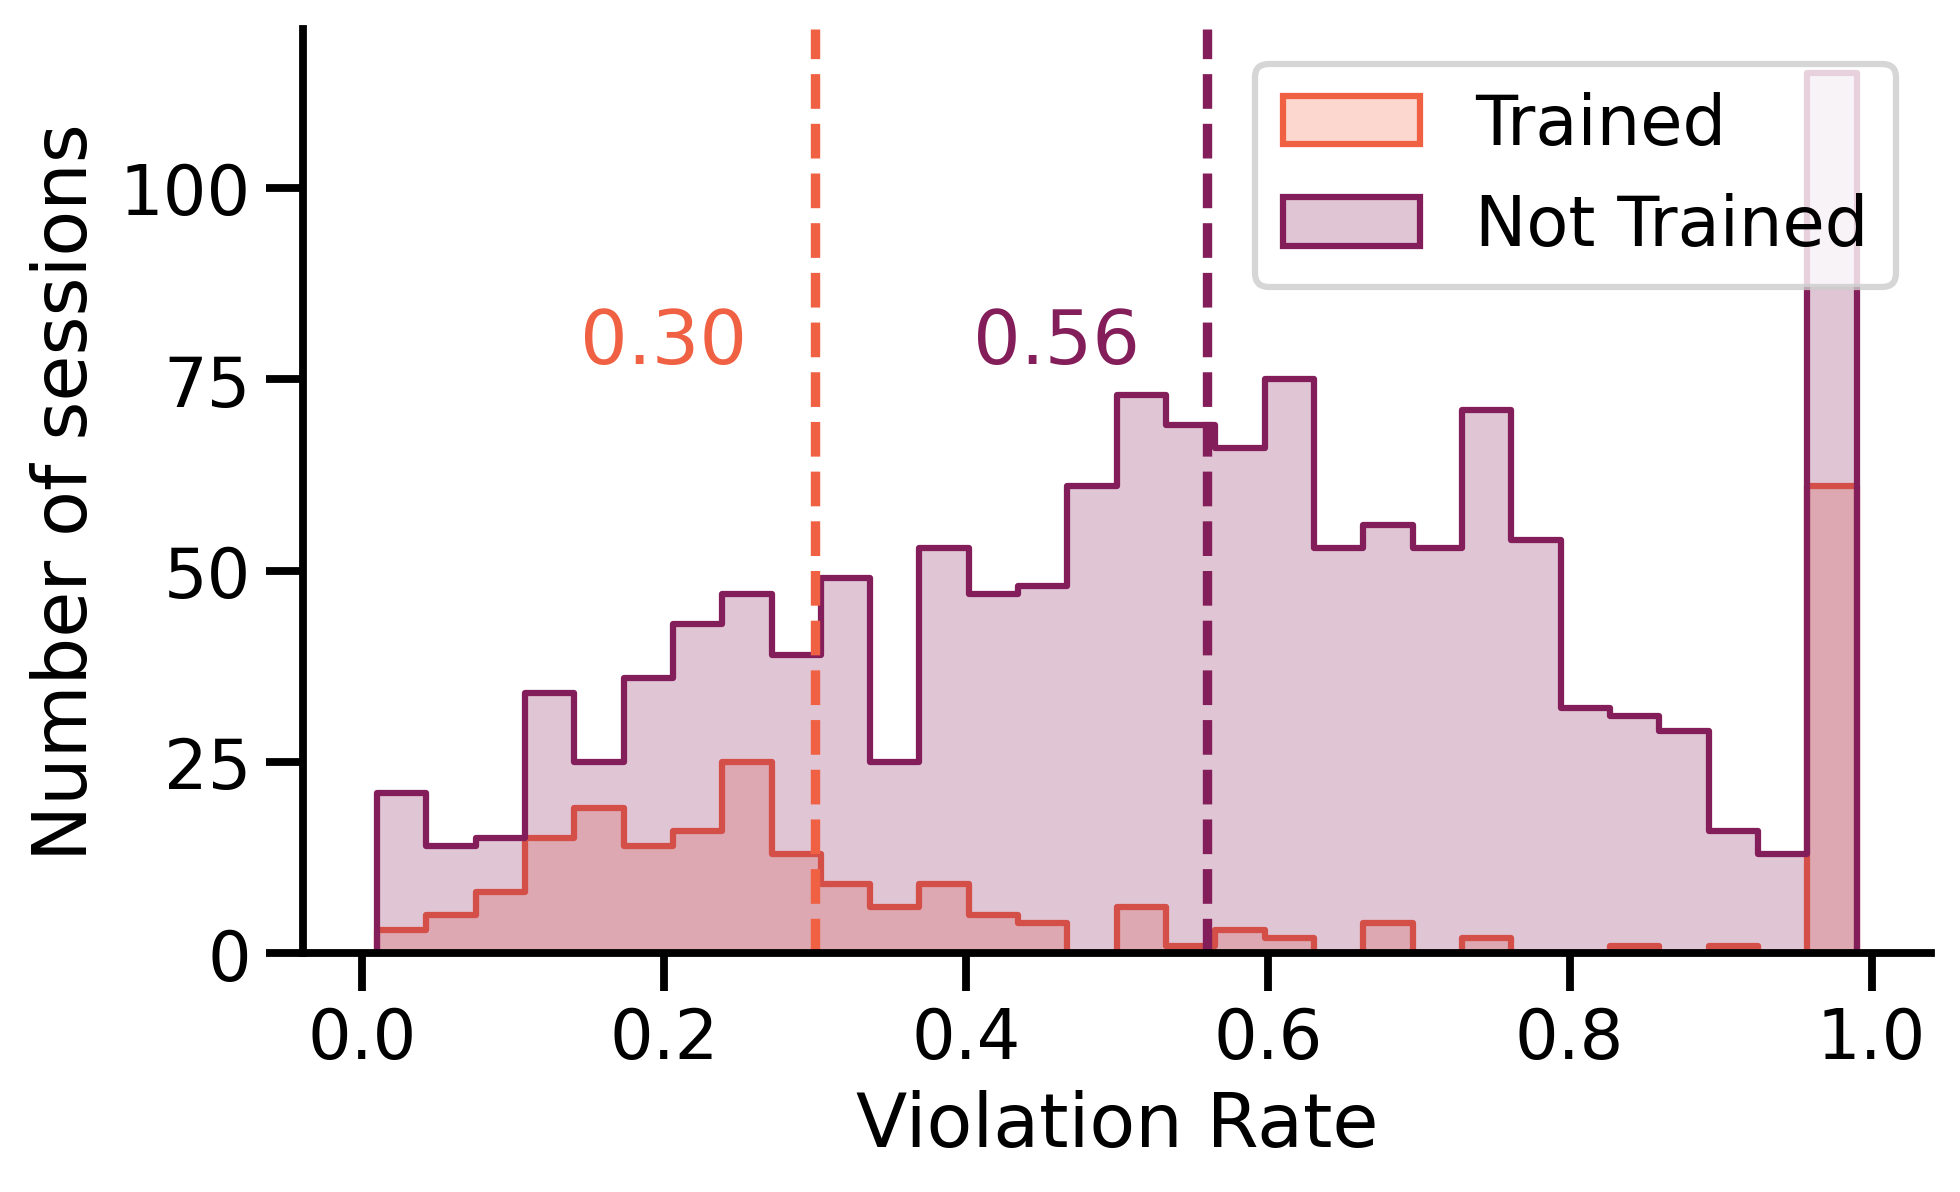

In [726]:
fig, ax = plt.subplots(figsize=(7, 4), dpi=300)

plot_df = cpoke_final_stage_animals_df.query(
    "stage_name =='gnp' and percent_violations != 0"
)  # lets look at animals that did reach the final stage
sns.histplot(
    plot_df,
    x="percent_violations",
    element="step",
    hue="trained",
    hue_order=hue_order,
    palette=palette,
    bins=30,
)
ax.legend(
    legend_labs,
    loc="upper right",
)
ax.set(
    # ylim=(0, 75),
    ylabel="Number of sessions",
    xlabel="Violation Rate",
)


for condition, sub_df in plot_df.groupby("trained"):
    median = sub_df["percent_violations"].median()

    ax.axvline(median, color=palette[condition], linestyle="--")
    ax.text(
        median - 0.1,
        75,
        f"{median:.2f}",
        ha="center",
        va="bottom",
        color=palette[condition],
    )
sns.despine()

### 3.3.4 Violation Rates for animals that Reached the Final Stage, Final Stage (Never)

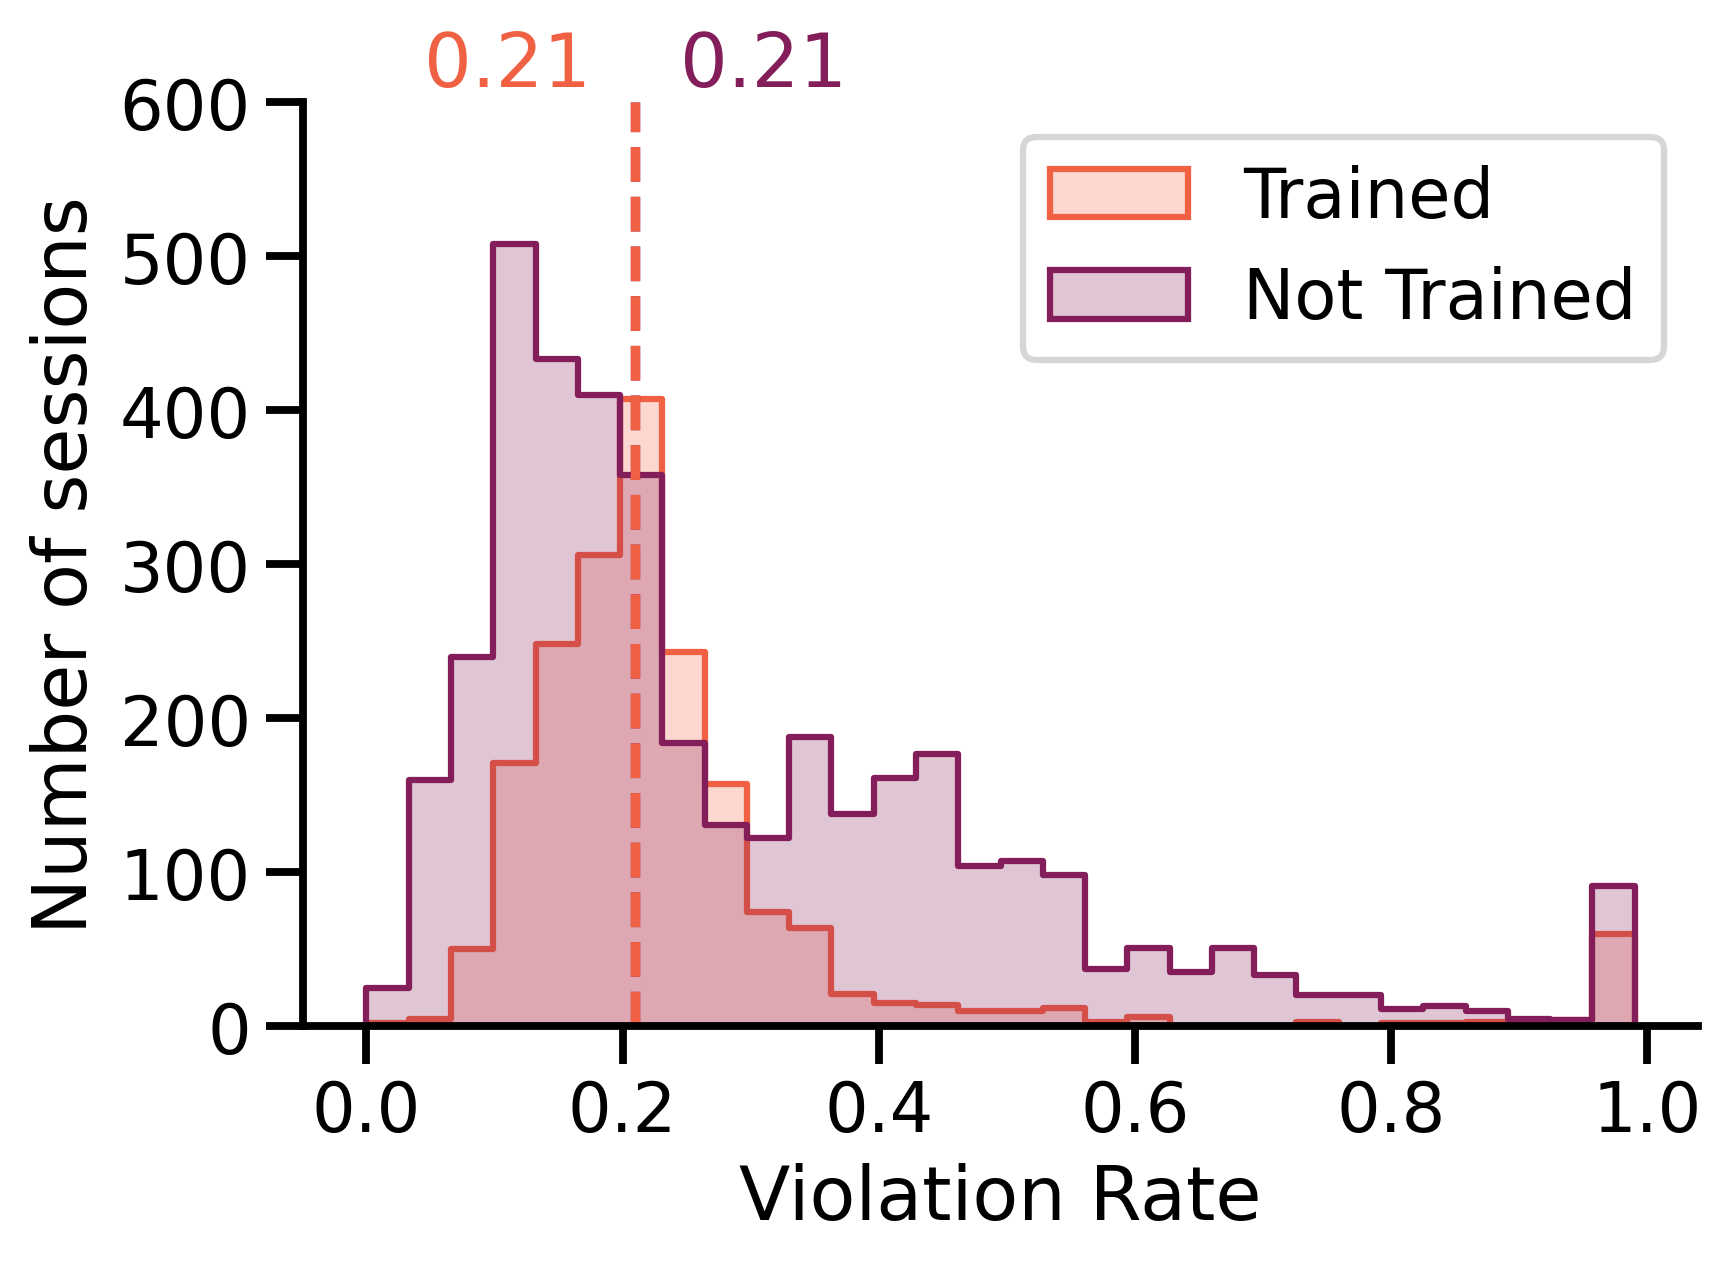

In [727]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

plot_df = cpoke_final_stage_animals_df.query("stage_name =='never'")
sns.histplot(
    plot_df,
    x="percent_violations",
    element="step",
    hue="trained",
    hue_order=hue_order,
    palette=palette,
    bins=30,
)
ax.legend(legend_labs, loc="upper right")
ax.set(
    ylim=(0, 600),
    ylabel="Number of sessions",
    xlabel="Violation Rate",
)

for condition, sub_df in plot_df.groupby("trained"):
    median = sub_df["percent_violations"].median()

    ax.axvline(median, color=palette[condition], linestyle="--")
    if condition:
        xloc = median - 0.1
    else:
        xloc = median + 0.1
    ax.text(
        xloc,
        600,
        f"{median:.2f}",
        ha="center",
        va="bottom",
        color=palette[condition],
    )
sns.despine()

### 3.3.5 Violation Rate by Hit Rate

<Axes: xlabel='percent_violations', ylabel='total_correct'>

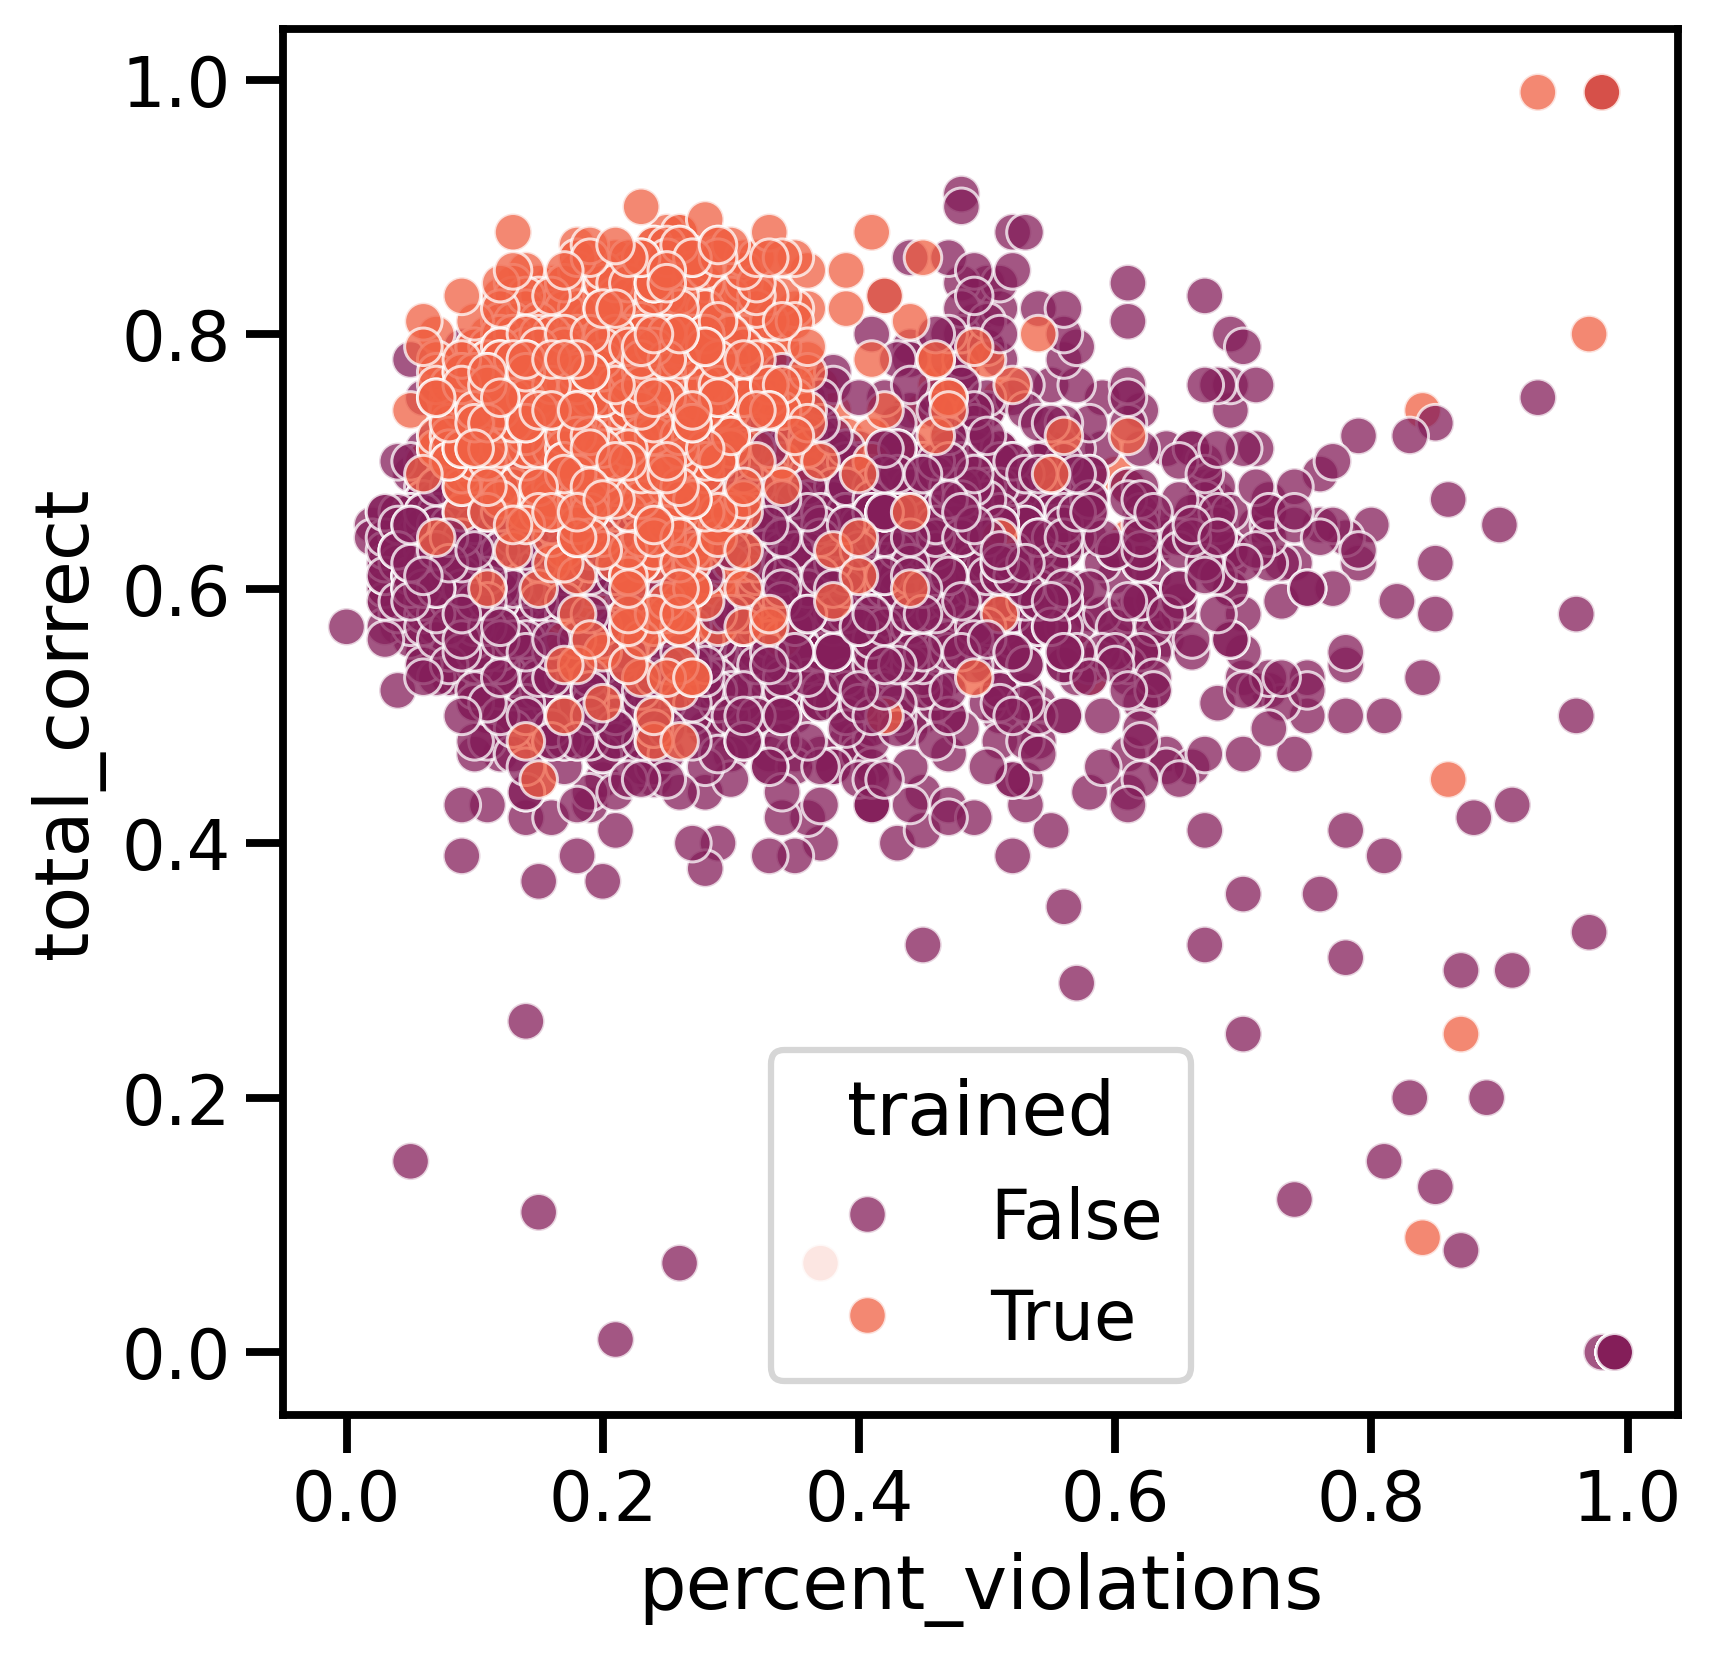

In [664]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
sns.scatterplot(
    data=cpoke_df.query("stage_name == 'never' and n_done_trials > 50"),
    x="percent_violations",
    y="total_correct",
    hue="trained",
    alpha=0.75,
    palette="rocket",
    hue_order=[False, True],
)

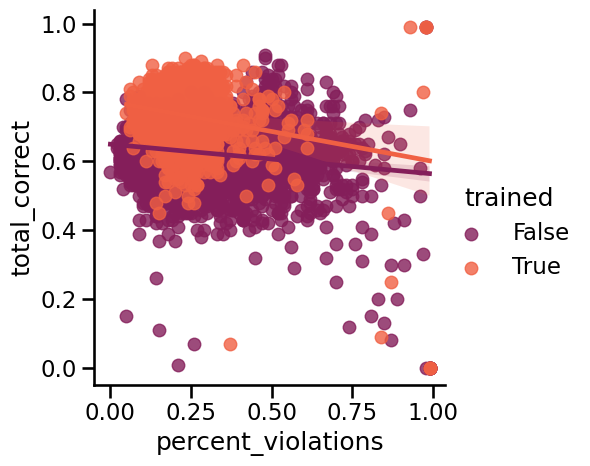

In [665]:
sns.lmplot(
    data=cpoke_df.query("stage_name == 'never' and n_done_trials > 50"),
    x="percent_violations",
    y="total_correct",
    hue="trained",
    hue_order=[False, True],
    palette="rocket",
)

### 3.3.6 Linear Regression of Violation & Hit Rate

In [569]:
session_agg_perf = (
    cpoke_df.query("stage_name == 'never' and n_done_trials > 50")
    .groupby("ratname")
    .agg({"percent_violations": "mean", "total_correct": "mean", "trained": "first"})
    .reset_index()
)

In [308]:
session_agg_perf.head()

ratname  percent_violations  total_correct  trained
0    D093            0.485403       0.503871    False
1    D099            0.504444       0.558889    False
2    D102            0.363421       0.424211    False
3    E160            0.358649       0.590541    False
4    E161            0.337698       0.680935    False

In [570]:
def univariate_linear_regression(df, x, y, print_results=True):
    """
    Performs univariate linear regression on given data.

    params
    -------
    df: pd.DataFrame
        Dataframe containing the data.
    x: str
        Name of the feature to be used as predictor.
    y: str
        Name of the feature to be used as target.

    Returns:
    - results (RegressionResults): Fitted regression model results.
    """

    X = df[x].values.reshape(-1, 1)
    y = df[y].values.reshape(-1, 1)
    X = sm.add_constant(X)

    model = sm.OLS(y, X)
    results = model.fit()

    if print_results:
        print(results.summary())

    return results


def plot_univariate_linear_regression(results, ax=None, **kwargs):
    """
    Plots the linear regression model and data points.

    Parameters:
    - results (RegressionResults): Fitted regression model results.
    - ax (matplotlib axis, optional): Axis on which to plot.
    - kwargs (dict): Additional settings for plot axis.

    Returns:
    - ax (matplotlib axis): Axis containing the plot.
    """

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    slope = results.params[1]
    intercept = results.params[0]

    # Get x and y data from the results
    x_data = results.model.exog[:, 1]
    y_data = results.model.endog

    # Determine the range for the line model
    x_line = np.linspace(min(x_data) * 0.5, max(x_data) * 1.5, 100)
    y_line = slope * x_line + intercept

    ax.scatter(x_data, y_data, color="black", label="Data")
    ax.plot(x_line, y_line, color="salmon", label="Regression Line")

    # Set axis limits, labels, title etc. based on kwargs
    ax.set(**kwargs)

    # Add text to upper right corner
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.text(xlim[1] * 0.75, ylim[1] * 0.75, f"$R^2$ = {results.rsquared_adj:.2f}")

    return ax

In [571]:
results = univariate_linear_regression(
    session_agg_perf, x="percent_violations", y="total_correct", print_results=True
)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     5.539
Date:                Tue, 27 Aug 2024   Prob (F-statistic):             0.0279
Time:                        18:12:43   Log-Likelihood:                 29.370
No. Observations:                  24   AIC:                            -54.74
Df Residuals:                      22   BIC:                            -52.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7249      0.040     18.296      0.0

<Axes: title={'center': 'Hit Rate ~ Violation Rate'}, xlabel='Session Avg. Violation Rate', ylabel='Session Avg. Hit Rate'>

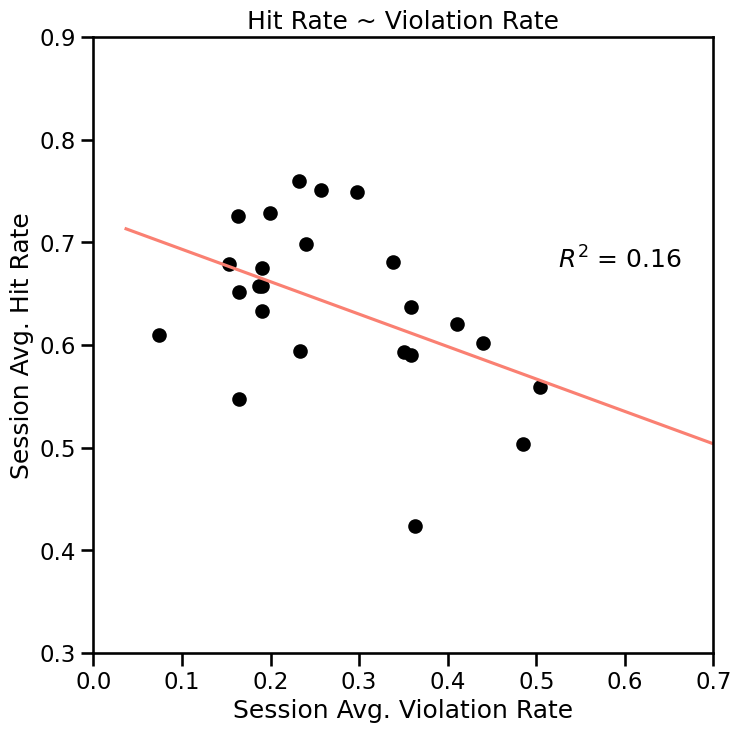

In [572]:
plot_univariate_linear_regression(
    results,
    xlabel="Session Avg. Violation Rate",
    ylabel="Session Avg. Hit Rate",
    title=f"Hit Rate ~ Violation Rate",
    ylim=(0.3, 0.9),
    xlim=(0, 0.7),
)

Text(0.5, 0.7, '$R^2$ = 0.16')

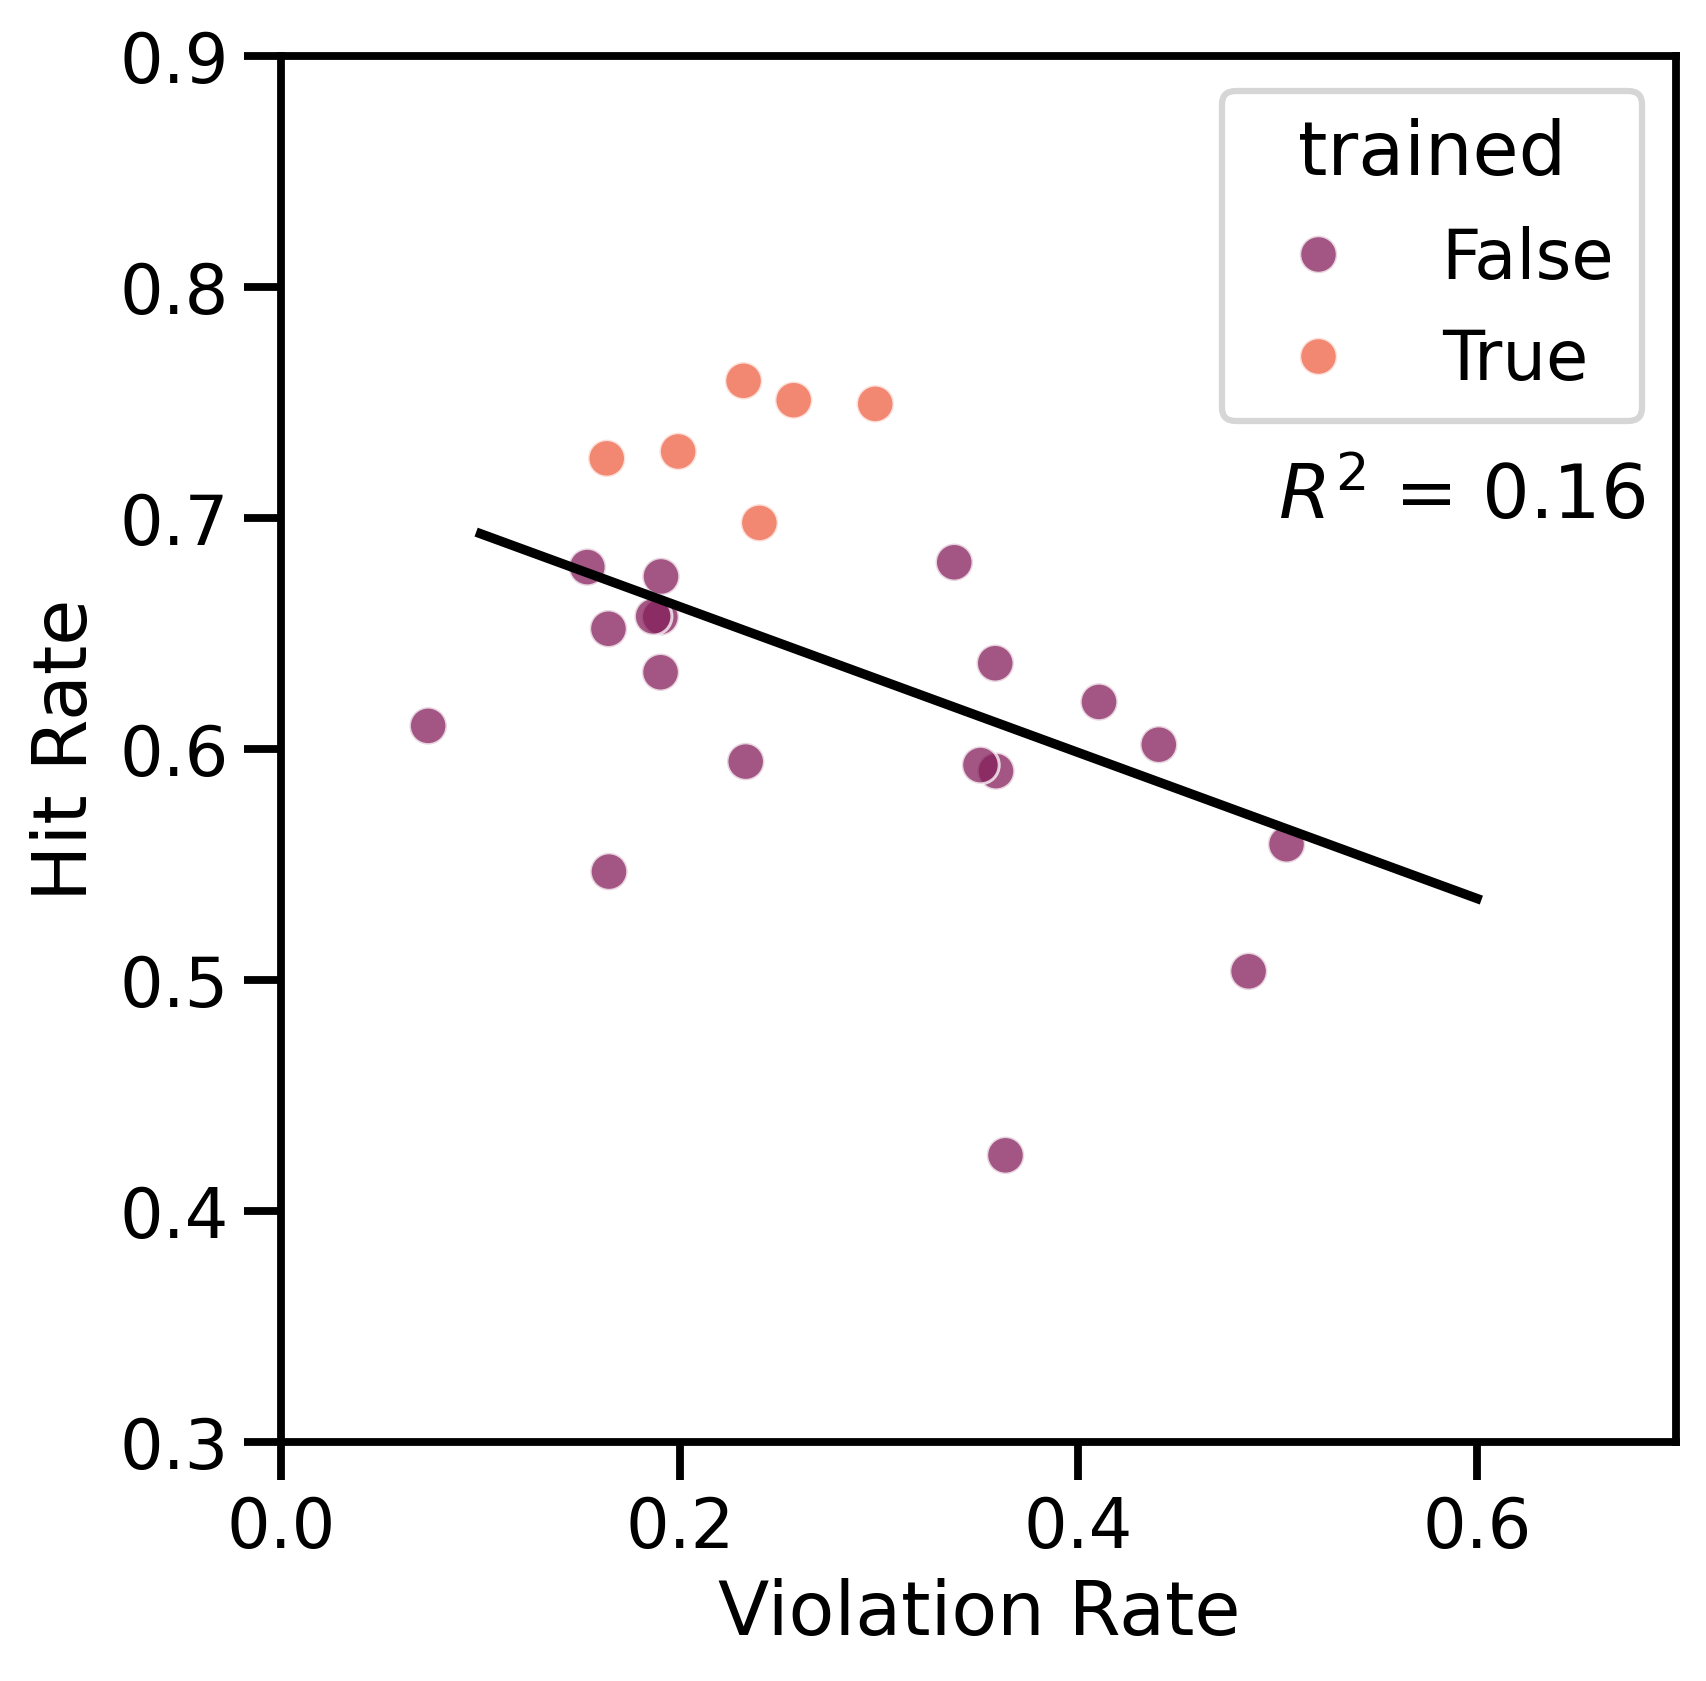

In [666]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
sns.scatterplot(
    data=session_agg_perf,
    x="percent_violations",
    y="total_correct",
    hue="trained",
    alpha=0.75,
    palette="rocket",
    hue_order=[False, True],
)

# ax.legend(
#     ["Not Trained", "Trained"],
# )


# Get slope, intercept, x and y data from the results
slope = results.params[1]
intercept = results.params[0]
x_data = results.model.exog[:, 1]
y_data = results.model.endog

# Determine the range for the line model
x_line = np.linspace(0.1, 0.6, 100)
y_line = slope * x_line + intercept


ax.plot(x_line, y_line, color="black", label="Regression Line")
ax.set(ylim=(0.3, 0.9), xlim=(0, 0.7), xlabel="Violation Rate", ylabel="Hit Rate")
ax.text(0.5, 0.7, f"$R^2$ = {results.rsquared_adj:.2f}")


[(0.3, 0.9),
 (0.0, 0.7),
 Text(0.5, 0, 'Violation Rate'),
 Text(0, 0.5, 'Hit Rate')]

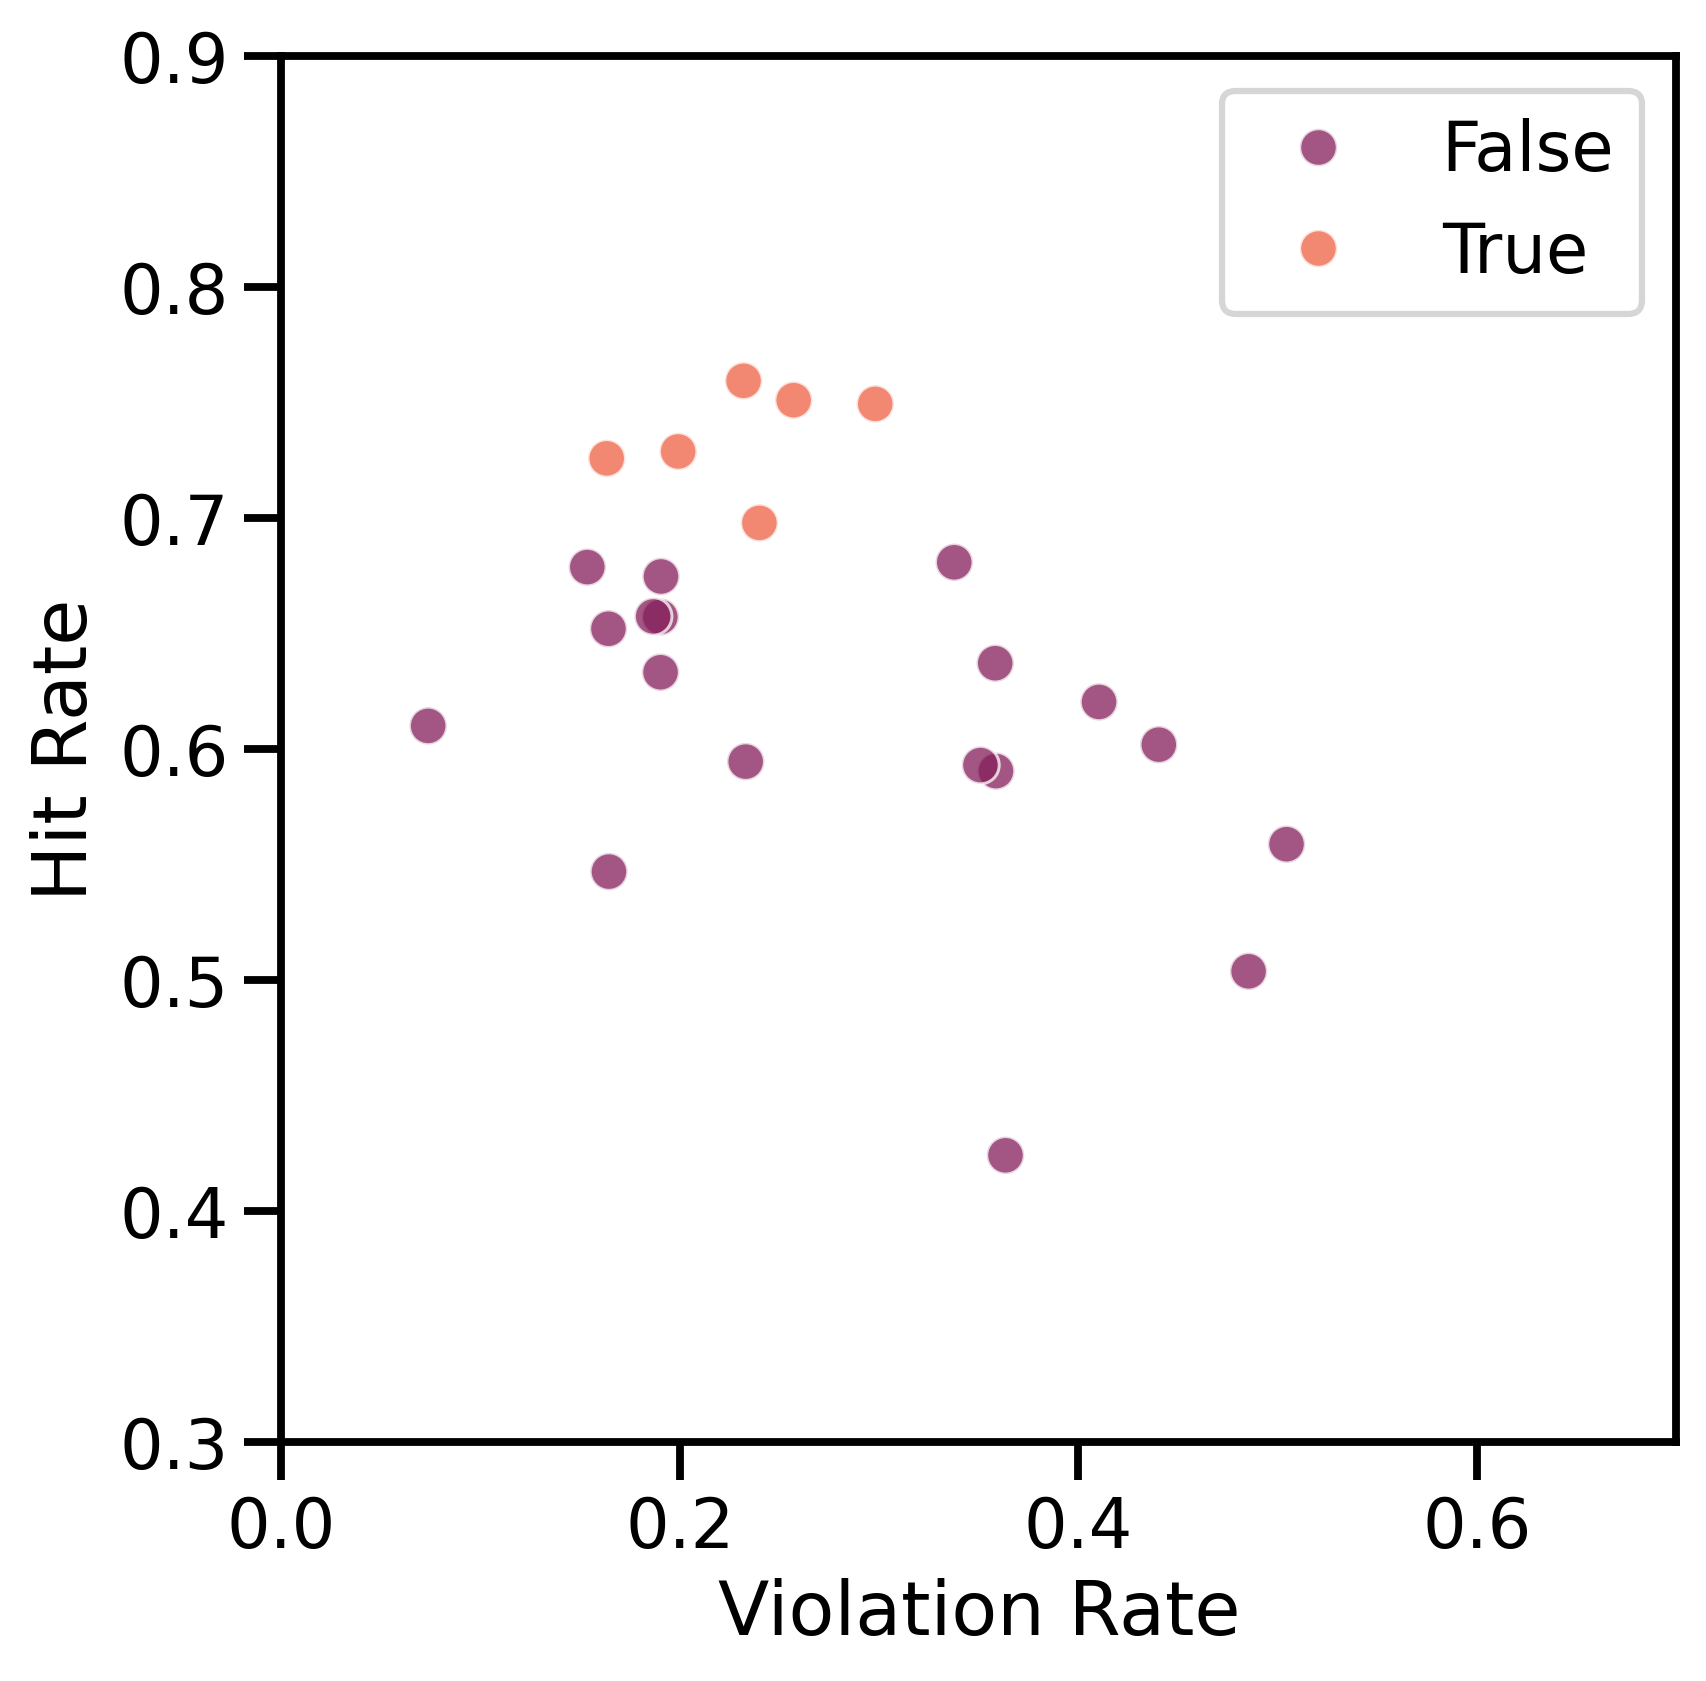

In [731]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
sns.scatterplot(
    data=session_agg_perf,
    x="percent_violations",
    y="total_correct",
    hue="trained",
    alpha=0.75,
    palette=palette,
    hue_order=[False, True],
)

ax.legend(
    # ["Not Trained", "Trained"],
)
ax.set(ylim=(0.3, 0.9), xlim=(0, 0.7), xlabel="Violation Rate", ylabel="Hit Rate")

# # label by ratname
# for i, row in session_agg_perf.iterrows():
#     ax.text(
#         row["percent_violations"],
#         row["total_correct"],
#         row["ratname"],
#         ha="center",
#         va="bottom",
#         color="black",
#     )

## 3.4 Length of Training

In [578]:
max_date = pwm_df.sessiondate.max()
min_date = pwm_df.sessiondate.min()

print(f"Data from {min_date} to {max_date}")

Data from 2020-07-18 to 2024-03-18


In [582]:
sess_starts = (
    pwm_df.groupby("ratname").sessiondate.min().reset_index().sort_values("sessiondate")
)
sess_starts.min(), sess_starts.max()

(ratname              D083
 sessiondate    2020-07-18
 dtype: object,
 ratname              Y004
 sessiondate    2022-05-06
 dtype: object)

In [585]:
pwm_df.columns

Index(['sessid', 'ratname', 'hostname', 'experimenter', 'starttime', 'endtime',
       'sessiondate', 'n_done_trials', 'comments', 'settings_file',
       'settings_path', 'data_file', 'data_path', 'video_file', 'video_path',
       'protocol', 'total_correct', 'right_correct', 'left_correct',
       'percent_violations', 'brokenbits', 'protocol_data', 'left_pokes',
       'center_pokes', 'right_pokes', 'technotes', 'IP_addr', 'crashed',
       'foodpuck', 'species', 'stage_name', 'stage_number', 'not_sound_rule',
       'trained'],
      dtype='object')

In [597]:
days_in_stage = (
    pwm_df.groupby(["ratname", "stage_name", "trained", "not_sound_rule"])
    .sessiondate.nunique()
    .reset_index()
    .rename(columns={"sessiondate": "n_days"})
)

days_in_stage.head()

ratname stage_name  trained  not_sound_rule  n_days
0    D083    delayed    False            True       9
1    D083        gnp    False            True     114
2    D083      spoke    False            True       6
3    D084     always    False            True      12
4    D084    delayed    False            True      31

<Axes: xlabel='stage_name', ylabel='n_days'>

/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 16.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


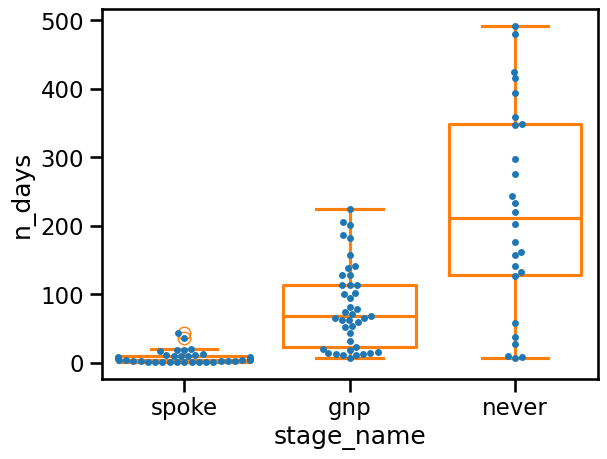

In [630]:
sns.swarmplot(
    data=days_in_stage,
    x="stage_name",
    y="n_days",
    order=["spoke", "gnp", "never"],
)

sns.boxplot(
    data=days_in_stage,
    x="stage_name",
    y="n_days",
    order=["spoke", "gnp", "never"],
    fill=False,
)

Box plot of all the animals, trained vs untrained, wheather they made it to sound rule or not

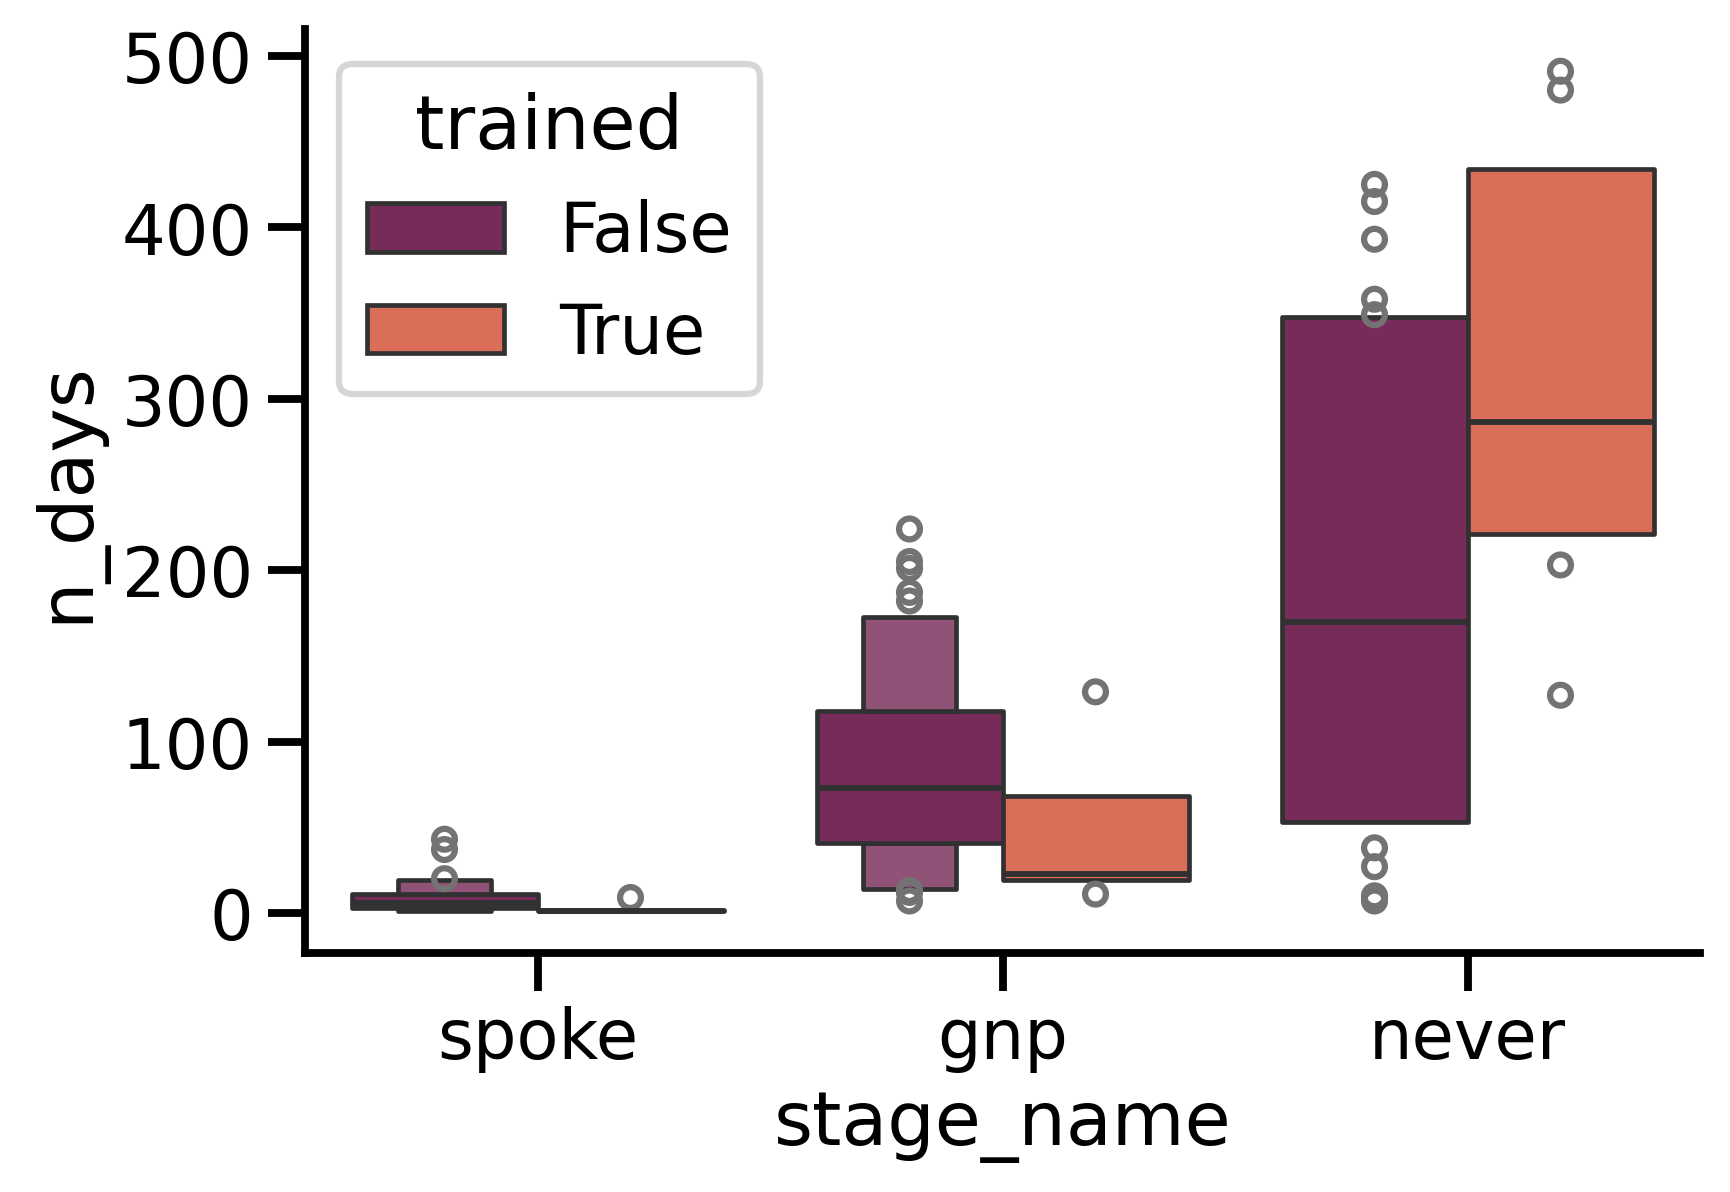

In [728]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
ax.legend(
    ["Not Trained", "Trained"],
)
sns.boxenplot(
    data=days_in_stage,
    x="stage_name",
    y="n_days",
    hue="trained",
    palette=palette,
    order=["spoke", "gnp", "never"],
    ax=ax,
)
sns.despine()

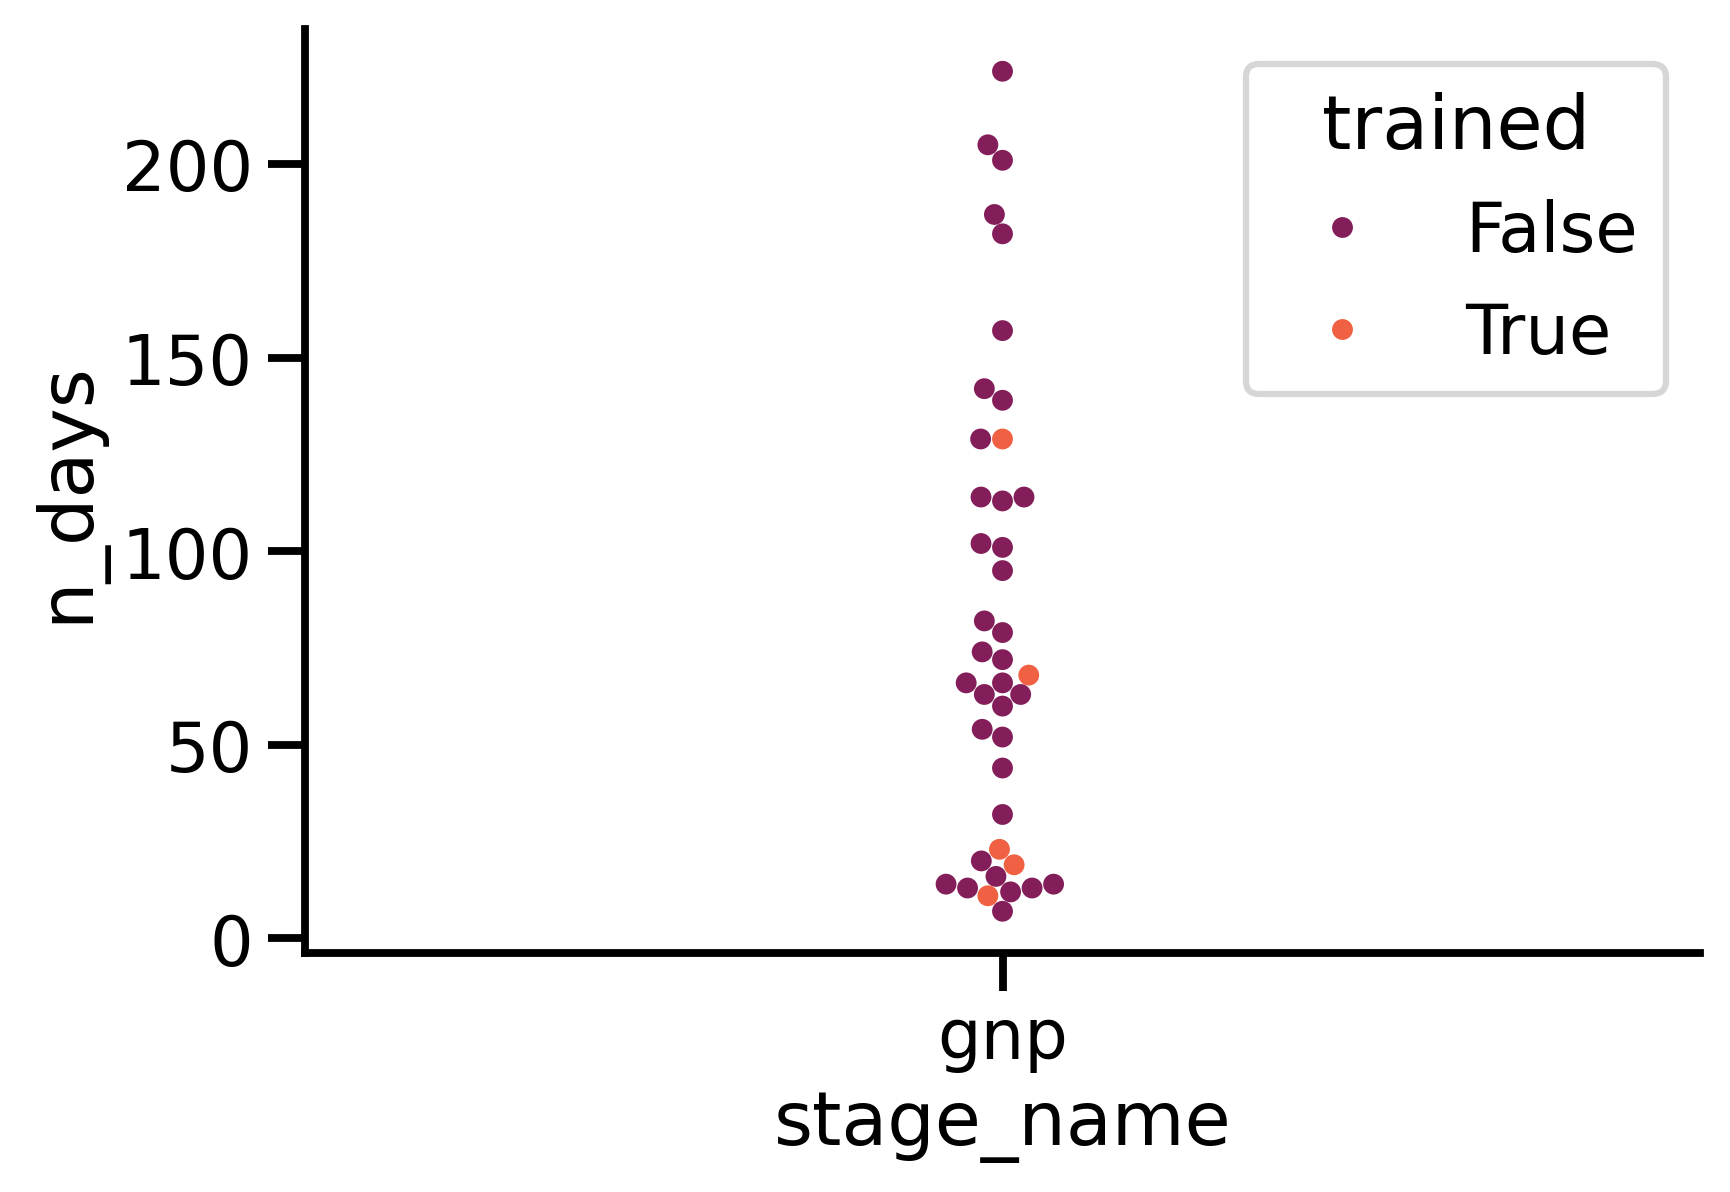

In [729]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
ax.legend(
    ["Not Trained", "Trained"],
)
sns.swarmplot(
    data=days_in_stage,
    x="stage_name",
    y="n_days",
    hue="trained",
    palette=palette,
    order=["gnp"],
    ax=ax,
)
sns.despine()

<Axes: xlabel='n_days', ylabel='Count'>

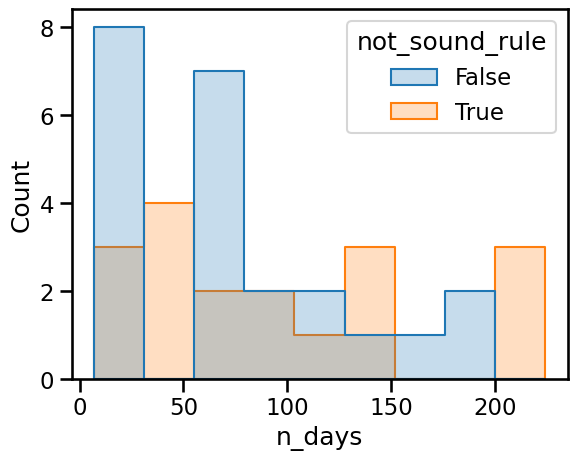

In [624]:
sns.histplot(
    days_in_stage.query("stage_name == 'gnp'"),
    x="n_days",
    hue="not_sound_rule",
    element="step",
    binwidth=25,
)

Only animals that made it to final sound rule stages